In [2]:
import findspark
import os
findspark.init(os.environ['SPARK_HOME'])

import folium
from IPython.core.display import display, HTML
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from pyspark.sql import *
from pyspark.sql.functions import *
import re
import scipy as sp
from scipy import stats
import seaborn as sns
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.datasets.samples_generator import make_blobs
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler

%matplotlib inline

spark = SparkSession.builder.getOrCreate()

In [4]:
dataframe = pd.read_csv('../data/processed/clean_food_cities_arrond_with_tax.csv')
dataframe = dataframe.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
dataframe.head()

,Nombre de foyers fiscaux,Nombre de foyers fiscaux imposés,Mean reference fiscal income (in k€),city_tag,food_item_index,nutrition-score-fr_100g,nutrition-score-uk_100g,nutrition_grade_numeric,serving_size,energy_100g,...,Share of retreat pension revenue (%),Share of heritage revenue and other (%),Share of social benefits revenue (%),Share of taxes (%),City name,Department,Region,custom_arrondissement_code,city_name,city_tag_from_food_item
0,206,108,27.468762,apremont,431441,16.0,16.0,4,NaN,883.0,...,NaN,NaN,NaN,NaN,Apremont,10,84,1004,apremont,apremont-vendee-france
1,206,108,27.468762,apremont,348749,15.0,15.0,4,NaN,703.0,...,NaN,NaN,NaN,NaN,Apremont,10,84,1004,apremont,apremont-vendee-france
2,206,108,27.468762,apremont,348720,16.0,16.0,4,NaN,900.0,...,NaN,NaN,NaN,NaN,Apremont,10,84,1004,apremont,apremont-vendee-france
3,206,108,27.468762,apremont,348741,11.0,11.0,4,50 g (1 tranche),514.0,...,NaN,NaN,NaN,NaN,Apremont,10,84,1004,apremont,apremont-vendee-france
4,206,108,27.468762,apremont,348708,15.0,15.0,4,Une tranche 100 g,699.0,...,NaN,NaN,NaN,NaN,Apremont,10,84,1004,apremont,apremont-vendee-france


# 1. Distribution of the products per nutrition grade

* Nutrition grade has integer values between 1 and 5, 1 indicating healthy food items and 5 describing unhealthy items.

* Nutrition score (UK or Fr.) has values between -15 and 40. -15 indicates a healthy food item, 40 indicates an unhealthy food item. 

The correspondence between the two of them for solid foods is:

* Nutrition grade = 1 : nutrition score $\in [-15, : -1]$
* Nutrition grade = 2 : nutrition score $\in [0, 2]$
* Nutrition grade = 3 : nutrition score $\in [3, 10]$
* Nutrition grade = 4 : nutrition score $\in [11, 18]$
* Nutrition grade = 5 : nutrition score $\in [19, 40]$

The correspondence between the two of them for beverages is:

* Nutrition grade = 1 : Water
* Nutrition grade = 2 : nutrition score $\in [-15, 1]$
* Nutrition grade = 3 : nutrition score $\in [2, 5]$
* Nutrition grade = 4 : nutrition score $\in [6, 9]$
* Nutrition grade = 5 : nutrition score $\in [10, 40]$

https://fr.openfoodfacts.org/nutriscore

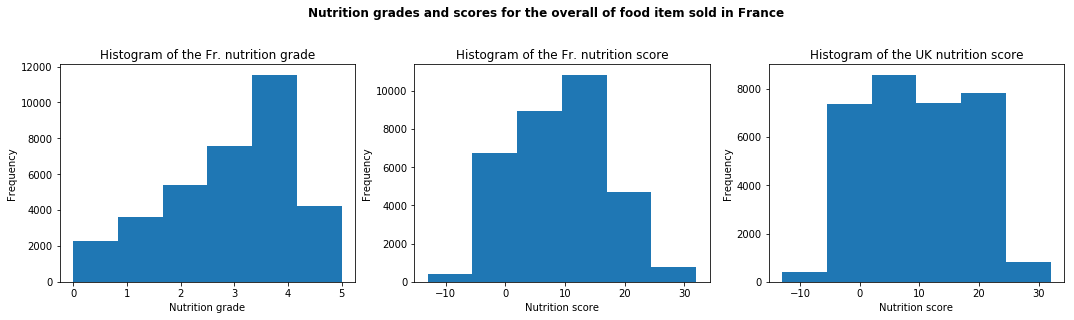

In [4]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))
f.suptitle("Nutrition grades and scores for the overall of food item sold in France", 
           y=1.08, fontweight="bold")
dataframe['nutrition_grade_numeric'].plot.hist(bins=6, ax=ax1)
ax1.set_title("Histogram of the Fr. nutrition grade")
ax1.set_ylabel("Frequency")
ax1.set_xlabel("Nutrition grade")

dataframe['nutrition-score-fr_100g'].plot.hist(bins=6, ax=ax2)
ax2.set_title("Histogram of the Fr. nutrition score")
ax2.set_ylabel("Frequency")
ax2.set_xlabel("Nutrition score")

dataframe['nutrition-score-uk_100g'].plot.hist(bins=6, ax=ax3)
ax3.set_title("Histogram of the UK nutrition score")
ax3.set_ylabel("Frequency")
ax3.set_xlabel("Nutrition score")
plt.show()

When we look at the nutrition grade histogram, we see that most of the products are labeled with a `3` or below, which indicates that healthy products are rare in comparison. 

When looking at the nutrition score histograms, the lack of healthy products is reinforced, however there are also a lot less **very** unhealthy products.

Since these 3 columns in our dataframe describe the same thing, we need to choose one. Intuitively, we would choose Nutrition grade because it already gives us a judgement on the quality of the food independently on if the item is solid food or beverage. 

We will however introduce two more nutrition metrics, and after that we will compute PCA on our dataframe to select only the relevant columns (i.e. columns that don't have the **exact same information**, columns that are not **redundant**). 

Reminder: `0` is equivalent to no data.

# 2. Implementation of custom nutrition scores

We introduce two more nutrition scores: calory density (the calories per serving size) and calory deviation.

Calory deviation is computed according to the nutritional standards that the calories that we consume in a day should be composed of $21 \%$ from protein, $53 \%$ from carbohydrates and $26 \%$ from fat. We then compute a deviation from this standard for each product. 

* In the first case (calory density), the metric describes how largely a product is packed with calories. Since obesity is linked with the density in calories of the ingested food items, this metric might be useful.

* In the second case (calory deviation), we aim at observing whether the products follow a healthy calory distribution. This metric would show us if a certain region has bad nutrition habits with respect to the ratios of nutriments they should eat. 

In [113]:
# we consider only the energy per 100g and the serving size
cals = dataframe[['energy_100g', 'serving_size']]
# we drop nan values, and serving sizes that are not relevant
cals = cals.dropna()
cals = cals.drop(cals[cals['serving_size'].str.contains("mg")].index)
cals = cals.drop(cals[cals['serving_size'].str.contains('oeuf')].index)
cals = cals.drop(cals[cals['serving_size'].str.contains('Deux tranches g')].index)
# we keep only the number of units of the usual measure unit for the product
cal = cals['serving_size'].str.replace('.*?(?P<number>[0-9.,]+)\s*(G|g|f|ml|mL).*', '\\g<number>')
cal = cal.str.replace('.*?(?P<number>[0-9.,]+)\s*(cl|cL).*', '\\g<number>0')
cal = cal.str.replace('.*?(?P<number>[0-9.,]+)\s*(Kg|L|l).*', '\\g<number>000')
# we remove values that are composed only of letters
cal = cal.str.replace('[^0-9]+', '')
cal = cal.replace('', np.nan)
cal = cal.dropna()
# we cast everything to float
cal = cal.str.replace(",", ".").astype('float')
cals.serving_size = cal
# and reinsert it in our dataframe
dataframe.loc[:, 'serving_size'] = cal

cal_density = cals.serving_size * cals.energy_100g / 100

**Note**

Proteins --> 21% of cals, 4 cals/g

Carbohydrates --> 53% of cals, 4 cals/g

Fat --> 26% of cals, 9 cals/g

In [114]:
# energy has to be divided by 4.184 to convert from Joules to kilocalories
energy_in_kcal_100g = dataframe.energy_100g / 4.184
cal_deviation = ((dataframe.fat_100g * 9 / energy_in_kcal_100g - 0.26)**2 + 
                (dataframe.carbohydrates_100g * 4 / energy_in_kcal_100g - 0.53)**2 +
                (dataframe.proteins_100g * 4 / energy_in_kcal_100g - 0.21)**2)/3
# we remove unknown and infinite values
cal_deviation.replace(np.infty, np.nan, inplace=True)
cal_deviation.dropna(inplace=True)
cal_deviation.describe()

count    21376.000000
mean         5.766193
std        563.562554
min          0.000044
25%          0.017735
50%          0.078327
75%          0.160257
max      58205.149533
dtype: float64

In [10]:
# we insert our columns in our dataframe
dataframe.loc[:, 'cal_density'] = cal_density
dataframe.loc[:, 'cal_deviation'] = cal_deviation
dataframe.head()

,Nombre de foyers fiscaux,Nombre de foyers fiscaux imposés,Mean reference fiscal income (in k€),city_tag,Unnamed: 0.1,food_item_index,nutrition-score-fr_100g,nutrition-score-uk_100g,nutrition_grade_numeric,serving_size,...,Share of social benefits revenue (%),Share of taxes (%),City name,Department,Region,custom_arrondissement_code,city_name,city_tag_from_food_item,cal_density,cal_deviation
0,206,108,27.468762,apremont,12869,431441,16.0,16.0,4,NaN,...,NaN,NaN,Apremont,10,84,1004,apremont,apremont-vendee-france,NaN,0.133987
1,206,108,27.468762,apremont,12875,348749,15.0,15.0,4,NaN,...,NaN,NaN,Apremont,10,84,1004,apremont,apremont-vendee-france,NaN,0.116812
2,206,108,27.468762,apremont,12881,348720,16.0,16.0,4,NaN,...,NaN,NaN,Apremont,10,84,1004,apremont,apremont-vendee-france,NaN,0.130923
3,206,108,27.468762,apremont,12887,348741,11.0,11.0,4,50.0,...,NaN,NaN,Apremont,10,84,1004,apremont,apremont-vendee-france,257.0,0.157268
4,206,108,27.468762,apremont,12893,348708,15.0,15.0,4,100.0,...,NaN,NaN,Apremont,10,84,1004,apremont,apremont-vendee-france,699.0,0.117324


# 3. Decide which columns to keep

In [117]:
dataframe.columns

Index(['Nombre de foyers fiscaux', 'Nombre de foyers fiscaux imposés',
       'Mean reference fiscal income (in k€)', 'city_tag', 'Unnamed: 0.1',
       'food_item_index', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g',
       'nutrition_grade_numeric', 'serving_size', 'energy_100g', 'fat_100g',
       'saturated-fat_100g', 'proteins_100g', 'carbohydrates_100g',
       'sugars_100g', 'fiber_100g', 'Median revenue euros',
       'Total poverty rate (%)', 'Poverty rate (-30) (%)',
       'Poverty rate (30-39) (%)', 'Poverty rate (40-49) (%)',
       'Poverty rate (50-59) (%)', 'Poverty rate (60-74) (%)',
       'Poverty rate (75+) (%)', 'Poverty rate (house owners) (%)',
       'Poverty rate (tenants) (%)', 'Share of activity revenue (%)',
       'Share of retreat pension revenue (%)',
       'Share of heritage revenue and other (%)',
       'Share of social benefits revenue (%)', 'Share of taxes (%)',
       'City name', 'Department', 'Region', 'custom_arrondissement_code',
      

In [118]:
numeric_cols = ['Nombre de foyers fiscaux', 'Nombre de foyers fiscaux imposés', 
                'Mean reference fiscal income (in k€)', 'food_item_index', 'nutrition-score-fr_100g', 
                'nutrition-score-uk_100g','nutrition_grade_numeric', 'serving_size', 'energy_100g', 
                'fat_100g','saturated-fat_100g', 'proteins_100g', 'carbohydrates_100g','sugars_100g', 
                'fiber_100g', 'Median revenue euros','Total poverty rate (%)', 'Poverty rate (-30) (%)',
       'Poverty rate (30-39) (%)', 'Poverty rate (40-49) (%)',
       'Poverty rate (50-59) (%)', 'Poverty rate (60-74) (%)',
       'Poverty rate (75+) (%)', 'Poverty rate (house owners) (%)',
       'Poverty rate (tenants) (%)', 'Share of activity revenue (%)',
       'Share of retreat pension revenue (%)',
       'Share of heritage revenue and other (%)',
       'Share of social benefits revenue (%)', 'Share of taxes (%)',
       'cal_density', 'cal_deviation']

In [119]:
for column in numeric_cols:
    nonna = len(dataframe[dataframe[column].apply(lambda x: not np.isnan(x))]) / len(dataframe)
    print('{:<45s}{:<30s}{:<55%}'.format(column, 'Number of non-na:', nonna))

Nombre de foyers fiscaux                     Number of non-na:             100.000000%                                            
Nombre de foyers fiscaux imposés             Number of non-na:             100.000000%                                            
Mean reference fiscal income (in k€)         Number of non-na:             100.000000%                                            
food_item_index                              Number of non-na:             100.000000%                                            
nutrition-score-fr_100g                      Number of non-na:             93.127226%                                             
nutrition-score-uk_100g                      Number of non-na:             93.127226%                                             
nutrition_grade_numeric                      Number of non-na:             100.000000%                                            
serving_size                                 Number of non-na:             55.44798

We decided to drop all columns that have less than $40 \%$ of non-NaN values.

In [120]:
dataframe = dataframe[['food_item_index', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g',
                       'nutrition_grade_numeric', 'serving_size', 'energy_100g', 'fat_100g',
                       'saturated-fat_100g', 'proteins_100g', 'carbohydrates_100g',
                       'sugars_100g', 'fiber_100g', 'cal_density', 'cal_deviation', 
                       'Median revenue euros', 'Mean reference fiscal income (in k€)', 'Nombre de foyers fiscaux',
                       'Nombre de foyers fiscaux imposés', 'City name', 'Department', 
                       'Region', 'custom_arrondissement_code']]

In our dataframe, we have now 5 types of columns:

* 1 column referring to the individual food item

* 5 columns referring to a nutrition score / grade of the food item

* 8 columns referring to the composition of the food item (sugar, fat, size...)

* 7 columns referring to the socio-economic characteristics of the city where the food item is sold

* 4 columns referring to the geographic characteristics where the item is sold


Since we can cluster all columns into 5 clear categories, we can infer that there are redundant columns in our dataframe. We wish to keep all geographic columns and the column having an ID for each food item. 

However, for our analysis we do not need 7 columns describing the socio-economic status of each city, so we wish to reduce the dimensionality of this category.

Likewise, we need to find only **one nutrition grade / score** that is relevant and hopefully **eliminate the 8 columns that refer to the food composition** (since their information is probably useless once we have an accurate nutrition grading system). 

In order to check if this dimensionality reduction can be performed, we use PCA.

In [11]:
economic_df = dataframe[['Median revenue euros',
       'Total poverty rate (%)', 'Share of activity revenue (%)',
       'Share of retreat pension revenue (%)',
       'Share of heritage revenue and other (%)',
       'Share of social benefits revenue (%)', 'Share of taxes (%)']].dropna()
norm_eco_df = StandardScaler().fit_transform(economic_df)

pca_eco = PCA(n_components=0.8)
pca_eco.fit(norm_eco_df)

print('Number of eigenvectors that explain 80% of the variance:', len(pca_eco.explained_variance_ratio_))
print(pca_eco.explained_variance_ratio_ )

Number of eigenvectors that explain 80% of the variance: 2
[0.51014067 0.29469574]


<Figure size 720x504 with 0 Axes>

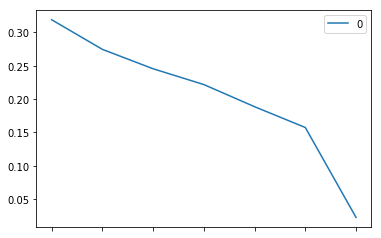

In [12]:
pca_eco_df = pd.DataFrame(pca_eco.components_, columns=economic_df.columns)
ex_var_eco_df = (pd.DataFrame(pca_eco.explained_variance_ratio_)).transpose()
feat_score_eco = ex_var_eco_df.dot(pca_eco_df).abs()

plt.figure(figsize=(10, 7))
feat_score_eco.transpose().sort_values(by=0, ascending=False).plot()
plt.show()

In [13]:
feat_score_eco.transpose().sort_values(by=0, ascending=False)

,0
Share of activity revenue (%),0.318843
Share of retreat pension revenue (%),0.274420
Median revenue euros,0.245347
Total poverty rate (%),0.221681
Share of social benefits revenue (%),0.188484
Share of taxes (%),0.157322
Share of heritage revenue and other (%),0.022519


In [14]:
pd.set_option('display.max_columns', 50)
nutrition_df = dataframe[['nutrition-score-fr_100g', 'nutrition-score-uk_100g',
       'nutrition_grade_numeric', 'cal_density', 'cal_deviation', 'serving_size', 'energy_100g', 'fat_100g',
       'saturated-fat_100g', 'proteins_100g', 'carbohydrates_100g',
       'sugars_100g', 'fiber_100g']].dropna()
norm_nutri_df = StandardScaler().fit_transform(nutrition_df)

pca_nutri = PCA(n_components=0.8)
pca_nutri.fit(norm_nutri_df)

print('Number of eigenvectors that explain 80% of the variance:', len(pca_nutri.explained_variance_ratio_))
print(pca_nutri.explained_variance_ratio_ )

Number of eigenvectors that explain 80% of the variance: 5
[0.36433119 0.16232748 0.13068789 0.10154415 0.07578995]


In [15]:
pd.DataFrame(pca_nutri.components_, columns=nutrition_df.columns)

,nutrition-score-fr_100g,nutrition-score-uk_100g,nutrition_grade_numeric,cal_density,cal_deviation,serving_size,energy_100g,fat_100g,saturated-fat_100g,proteins_100g,carbohydrates_100g,sugars_100g,fiber_100g
0,0.428432,0.435085,0.394224,0.058210,0.016361,-0.025765,0.350529,0.368592,0.352224,0.132479,0.170072,0.185290,0.061767
1,-0.062570,-0.094963,-0.080154,0.121360,-0.058576,0.064016,0.205995,-0.187770,-0.240576,-0.269257,0.581336,0.467435,0.440307
2,0.035426,0.016813,0.038365,0.681247,-0.001446,0.704766,-0.054492,-0.023696,0.016013,-0.060659,-0.090204,-0.025907,-0.141140
3,-0.203767,-0.113381,-0.263375,0.136922,-0.231539,0.055640,0.304342,0.210576,0.071703,0.500172,0.019823,-0.391997,0.504449
4,-0.043678,-0.036901,-0.032220,0.032949,0.960471,0.030276,0.014591,0.011258,-0.047751,0.196580,0.093338,-0.063842,0.130900


<Figure size 720x504 with 0 Axes>

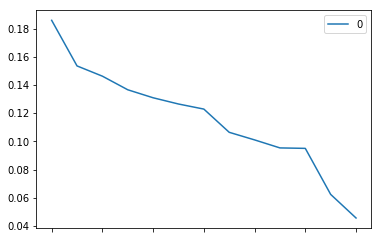

In [16]:
pca_nutri_df = pd.DataFrame(pca_nutri.components_, columns=nutrition_df.columns)
ex_var_nutri_df = (pd.DataFrame(pca_nutri.explained_variance_ratio_)).transpose()
feat_score_nutri = ex_var_nutri_df.dot(pca_nutri_df).abs()

plt.figure(figsize=(10,7))
feat_score_nutri.transpose().sort_values(by=0, ascending=False).plot()
plt.show()

In [17]:
feat_score_nutri.transpose().sort_values(by=0, ascending=False)

,0
energy_100g,0.186036
carbohydrates_100g,0.153628
cal_density,0.146339
fiber_100g,0.136677
nutrition-score-uk_100g,0.130987
nutrition-score-fr_100g,0.126562
fat_100g,0.122949
nutrition_grade_numeric,0.106444
serving_size,0.101054
sugars_100g,0.095355


In [18]:
total_df = dataframe[['nutrition-score-fr_100g', 'nutrition-score-uk_100g',
       'nutrition_grade_numeric', 'serving_size', 'energy_100g', 'fat_100g',
       'saturated-fat_100g', 'proteins_100g', 'carbohydrates_100g',
       'sugars_100g', 'fiber_100g', 'cal_density', 'cal_deviation', 'Median revenue euros',
       'Total poverty rate (%)', 'Share of activity revenue (%)',
       'Share of retreat pension revenue (%)',
       'Share of heritage revenue and other (%)',
       'Share of social benefits revenue (%)', 'Share of taxes (%)']].dropna()
norm_tot_df = StandardScaler().fit_transform(total_df)

pca = PCA(n_components=0.8)
pca.fit(norm_tot_df)

print('Number of eigenvectors that explain 95% of the variance:', len(pca.explained_variance_ratio_))

Number of eigenvectors that explain 95% of the variance: 7


In [19]:
pd.DataFrame(pca.components_, columns=total_df.columns)

,nutrition-score-fr_100g,nutrition-score-uk_100g,nutrition_grade_numeric,serving_size,energy_100g,fat_100g,saturated-fat_100g,proteins_100g,carbohydrates_100g,sugars_100g,fiber_100g,cal_density,cal_deviation,Median revenue euros,Total poverty rate (%),Share of activity revenue (%),Share of retreat pension revenue (%),Share of heritage revenue and other (%),Share of social benefits revenue (%),Share of taxes (%)
0,0.396640,0.403729,0.365844,-0.015402,0.376046,0.349837,0.331074,0.132522,0.159255,0.166558,0.058946,0.056118,0.024376,-0.147441,0.136456,-0.035278,-0.011560,-0.103553,0.161542,0.125513
1,0.124684,0.116531,0.116222,0.017344,0.117090,0.094466,0.104517,-0.035848,0.096166,0.103694,0.032219,0.044576,0.018060,0.485358,-0.421278,0.240648,-0.125708,0.276038,-0.441055,-0.376009
2,0.013076,0.005532,-0.004433,0.057381,0.039607,0.025348,0.007536,-0.033872,0.041305,0.098436,0.070644,0.061429,-0.018983,0.012064,0.056521,-0.600683,0.628489,0.432148,-0.093747,-0.133609
3,-0.055474,-0.092070,-0.078978,0.235246,0.095057,-0.190731,-0.194152,-0.343809,0.529590,0.461668,0.314814,0.283128,-0.037294,-0.049588,0.126777,0.083788,-0.101203,-0.044377,0.104136,-0.051803
4,0.065260,0.052612,0.085130,0.658207,-0.129267,-0.009092,0.044545,0.044886,-0.224014,-0.137721,-0.270391,0.615364,0.028890,-0.006503,-0.047666,0.001885,-0.002136,-0.035096,-0.030984,0.073592
5,-0.202953,-0.134037,-0.262266,0.121388,0.279285,0.219237,0.067947,0.396903,0.018310,-0.345634,0.604516,0.167166,-0.227674,0.036132,-0.031817,0.020406,-0.011663,-0.027607,-0.018986,0.010089
6,-0.050643,-0.046951,-0.044655,0.010219,0.041130,-0.006617,-0.084390,0.203310,0.148278,-0.047015,0.113905,0.026961,0.933693,-0.003301,-0.095772,-0.034062,0.050213,-0.059764,-0.070061,0.109150


In [20]:
selected_feat = feat_score_eco[feat_score_eco > 0.16].transpose().dropna().index
selected_feat = selected_feat.append(feat_score_nutri[feat_score_nutri > 0.16].transpose().dropna().index)

In [21]:
selected_df = dataframe[selected_feat].dropna()

In [22]:
selected_feat.transpose()#.sort_values(by=0, ascending=False)

Index(['Median revenue euros', 'Total poverty rate (%)',
       'Share of activity revenue (%)', 'Share of retreat pension revenue (%)',
       'Share of social benefits revenue (%)', 'energy_100g'],
      dtype='object')

<Figure size 720x504 with 0 Axes>

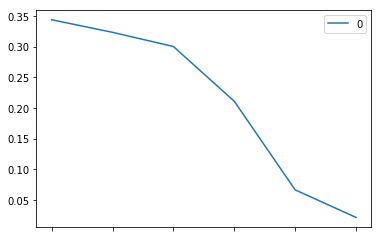

In [23]:
norm_selected_df = StandardScaler().fit_transform(selected_df)

pca_selected = PCA(n_components=0.8)
pca_selected.fit(norm_selected_df)

pca_selected_df = pd.DataFrame(pca_selected.components_, columns=selected_df.columns)
ex_var_selected_df = (pd.DataFrame(pca_selected.explained_variance_ratio_)).transpose()
feat_score_selected = ex_var_selected_df.dot(pca_selected_df).abs()

plt.figure(figsize=(10,7))
feat_score_selected.transpose().sort_values(by=0, ascending=False).plot()
plt.show()

selected_df = selected_df.reset_index(drop=True)

/home/wilhelm/Documents/EPFL/applied_data_analysis/.env/lib/python3.6/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


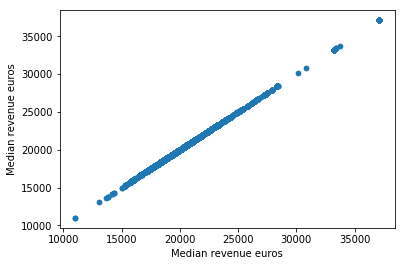

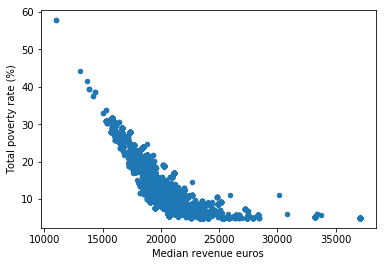

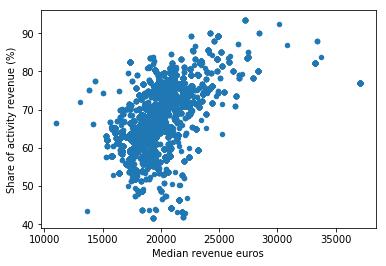

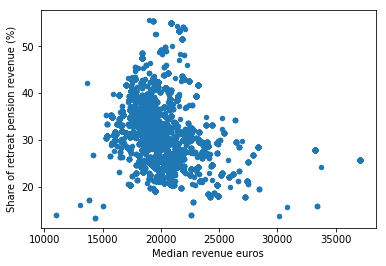

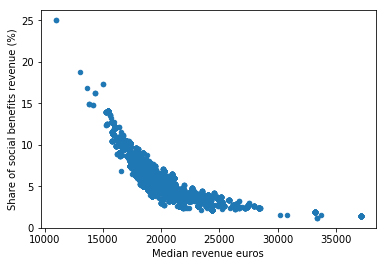

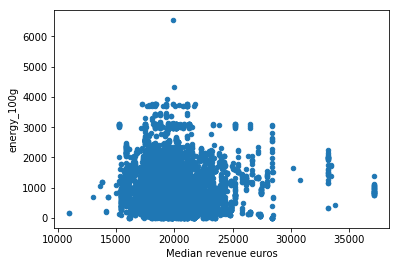

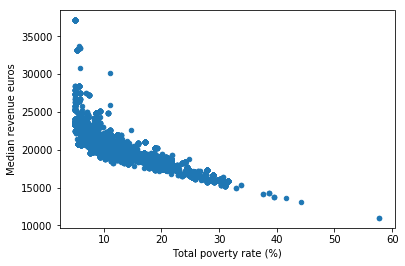

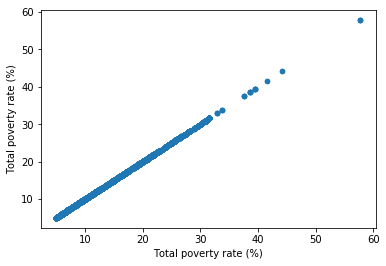

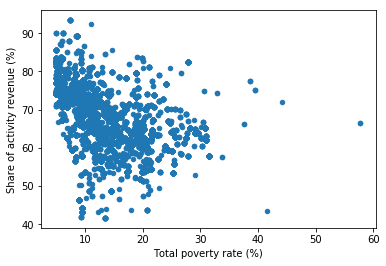

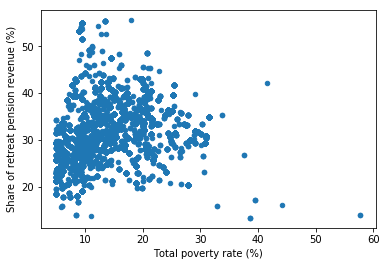

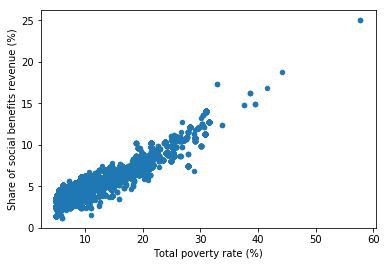

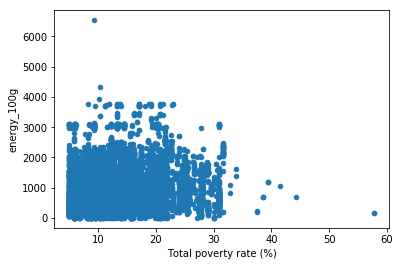

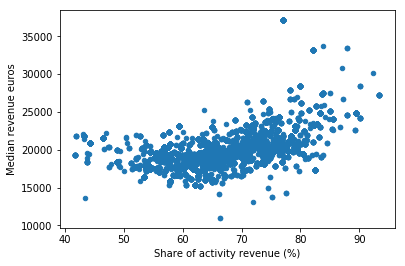

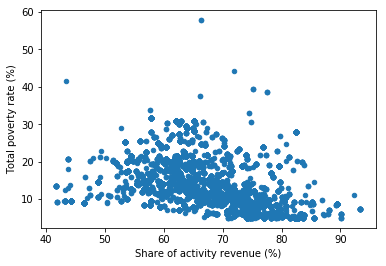

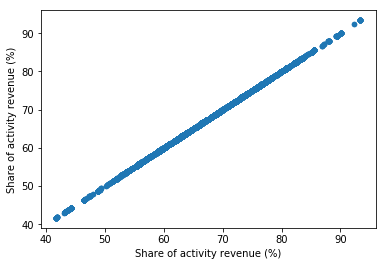

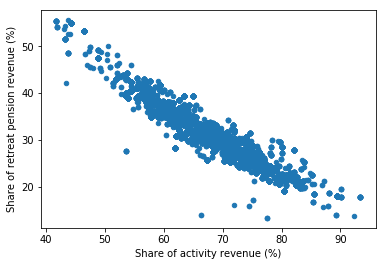

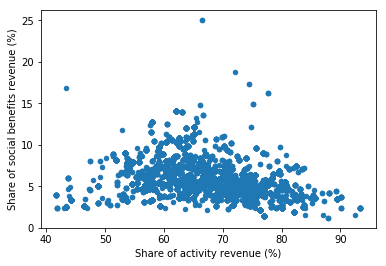

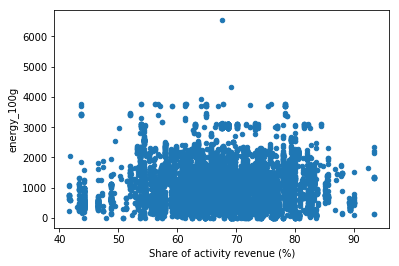

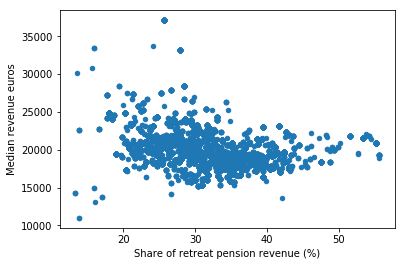

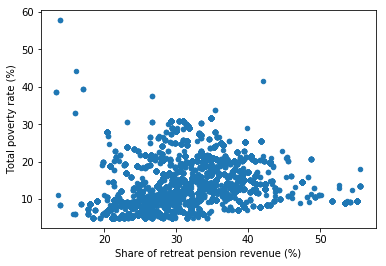

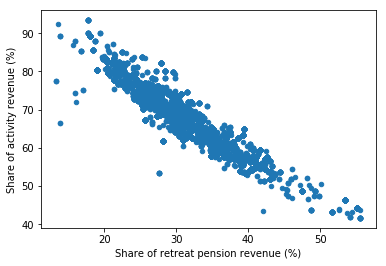

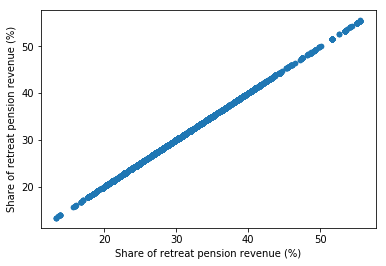

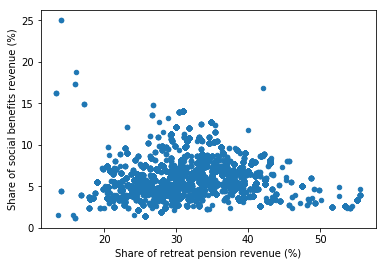

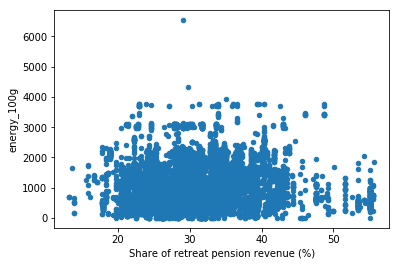

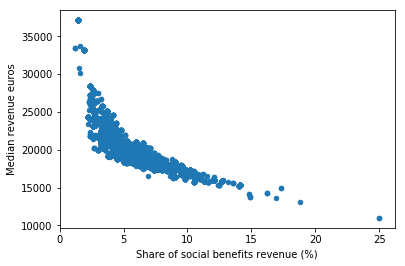

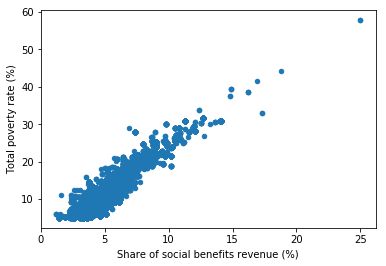

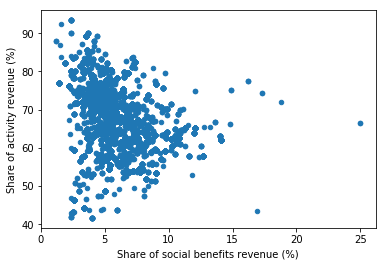

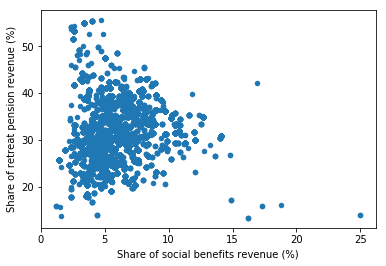

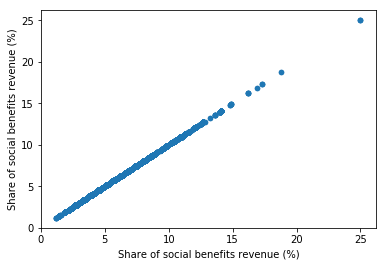

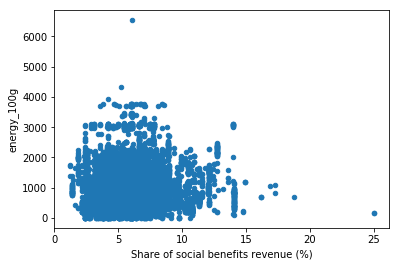

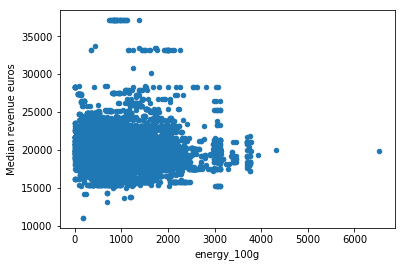

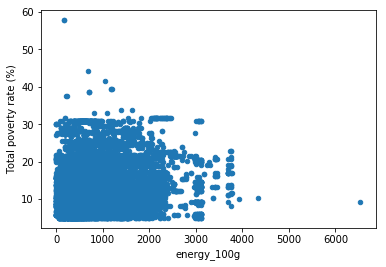

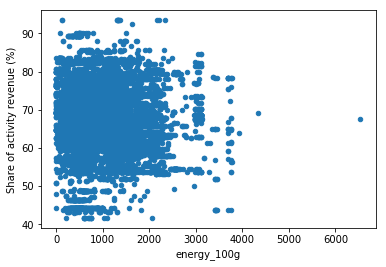

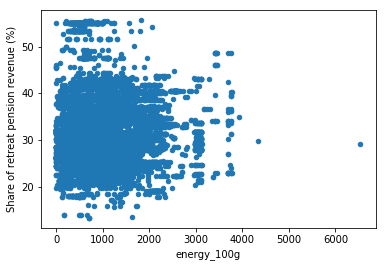

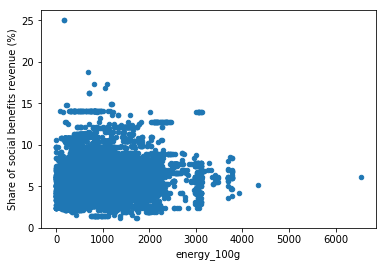

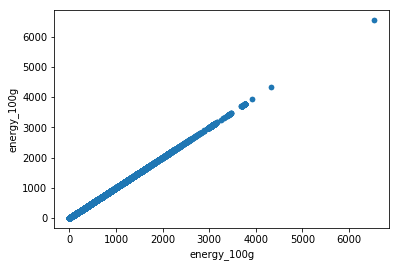

In [24]:
for feat in selected_feat:
    for feat2 in selected_feat:
        df = selected_df[[feat, feat2]]
        df.plot.scatter(x=feat, y=feat2)

In [25]:
grouped_selected = selected_df.groupby(selected_df['Median revenue euros']).mean()
grouped_selected = grouped_selected.reset_index(drop=True)
grouped_selected

,Total poverty rate (%),Share of activity revenue (%),Share of retreat pension revenue (%),Share of social benefits revenue (%),energy_100g
0,57.763975,66.4,13.9,25.0,167.000000
1,44.236082,72.0,16.1,18.8,682.000000
2,41.517338,43.4,42.1,16.9,1046.000000
3,39.508652,75.1,17.1,14.9,1189.333333
4,37.575382,66.2,26.7,14.8,217.500000
5,38.597398,77.6,13.3,16.2,699.000000
6,32.906468,74.5,15.9,17.3,953.500000
7,30.945912,63.0,30.4,14.0,2453.384615
8,33.801177,57.6,35.4,12.4,1508.500000
9,30.361424,60.5,33.4,12.5,1152.450000


In [27]:
def cluster(df, eps, min_samples):
    # Normalize
    X = StandardScaler().fit_transform(df)

    # Compute DBSCAN
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    print("Silhouette Coefficient: %0.3f"
          % metrics.silhouette_score(X, labels))

    # Plot result
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()
    
    return labels

Estimated number of clusters: 1
Estimated number of noise points: 31
Silhouette Coefficient: 0.439


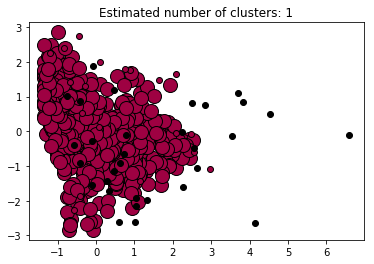

[-1 -1 -1 -1 -1 -1 -1 -1  0  0  0  0  0  0  0 -1  0  0 -1  0  0  0  0  0
  0  0  0 -1  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0
  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0 -1  0  0  0  0  0  0
  0  0  0  0  0  0  0  0 -1  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0
 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

In [28]:
labels = cluster(grouped_selected, 1, 5)
print(labels)

In [29]:
len(list(np.where(labels ==  1)[0]))

0

In [30]:
grouped_selected.loc[list(np.where(labels == 1)[0]), :]

,Total poverty rate (%),Share of activity revenue (%),Share of retreat pension revenue (%),Share of social benefits revenue (%),energy_100g


In [31]:
grouped_selected.loc[list(np.where(labels == 4)[0]), :]

,Total poverty rate (%),Share of activity revenue (%),Share of retreat pension revenue (%),Share of social benefits revenue (%),energy_100g


In [32]:
mutual_info_regression(X, y)

NameError: name 'X' is not defined

# 4. Aggregation

In [164]:
dataframe.columns

Index(['food_item_index', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g',
       'nutrition_grade_numeric', 'serving_size', 'energy_100g', 'fat_100g',
       'saturated-fat_100g', 'proteins_100g', 'carbohydrates_100g',
       'sugars_100g', 'fiber_100g', 'cal_density', 'cal_deviation',
       'Median revenue euros', 'Mean reference fiscal income (in k€)',
       'Nombre de foyers fiscaux', 'Nombre de foyers fiscaux imposés',
       'City name', 'Department', 'Region', 'custom_arrondissement_code'],
      dtype='object')

In [165]:
dataframe['total_revenue_city'] = dataframe['Nombre de foyers fiscaux'] * dataframe['Mean reference fiscal income (in k€)']

We have to remove the DOM-TOMS since the cultural differences are too large (Guadeloupe, Guyane, etc).

In [121]:
dom_tom = [1, 2, 4]
dataframe['Region'] = dataframe['Region'][dataframe['Region'].apply(lambda x: x not in dom_tom)]

In [167]:
count_city = dataframe.drop(columns=['Region', 'custom_arrondissement_code', 'Department']
                               ).dropna().groupby('City name').count()['food_item_index']
count_arr = dataframe.drop(columns=['Region', 'City name', 'Department']
                              ).dropna().groupby('custom_arrondissement_code').count()['food_item_index']
count_dep = dataframe.drop(columns=['Region', 'custom_arrondissement_code', 'City name']
                              ).dropna().groupby('Department').count()['food_item_index']
count_reg = dataframe.drop(columns=['Department', 'custom_arrondissement_code', 'City name']
                              ).dropna().groupby('Region').count()['food_item_index']

In [168]:
sum_city = dataframe.drop(columns=['Region', 'custom_arrondissement_code', 'Department']
                               ).dropna().groupby('City name').sum()
sum_arr = dataframe.drop(columns=['Region', 'City name', 'Department']
                              ).dropna().groupby('custom_arrondissement_code').sum()
sum_dep = dataframe.drop(columns=['Region', 'custom_arrondissement_code', 'City name']
                              ).dropna().groupby('Department').sum()
sum_reg = dataframe.drop(columns=['Department', 'custom_arrondissement_code', 'City name']
                              ).dropna().groupby('Region').sum()

In [180]:
mean_city = sum_city[['food_item_index', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g',
       'nutrition_grade_numeric', 'serving_size', 'energy_100g', 'fat_100g',
       'saturated-fat_100g', 'proteins_100g', 'carbohydrates_100g',
       'sugars_100g', 'fiber_100g', 'cal_density', 'cal_deviation',
       'Median revenue euros', 'Mean reference fiscal income (in k€)']].div(count_city, axis=0)
mean_city['total_revenue_city'] = sum_city['total_revenue_city'].div(sum_city['Nombre de foyers fiscaux'], axis=0)
                     
mean_arr = sum_arr.div(count_arr, axis=0)
mean_dep = sum_dep.div(count_dep, axis=0)
mean_reg = sum_reg.div(count_reg, axis=0)

In [175]:
type(count_city)

pandas.core.series.Series

In [181]:
mean_city.head()

,food_item_index,nutrition-score-fr_100g,nutrition-score-uk_100g,nutrition_grade_numeric,serving_size,energy_100g,fat_100g,saturated-fat_100g,proteins_100g,carbohydrates_100g,sugars_100g,fiber_100g,cal_density,cal_deviation,Median revenue euros,Mean reference fiscal income (in k€),total_revenue_city
City name,,,,,,,,,,,,,,,,,
Abbeville,397676.50,0.2,0.2,2.0,260.00,204.2,1.6,1.020,3.220,5.360,5.340,0.160,528.60,0.011563,16524.000000,18.691631,18.691631
Ablis,327468.25,2.5,2.5,2.5,223.75,486.0,4.7,1.675,10.775,6.975,2.225,1.175,1106.65,0.067953,24186.666667,32.541324,32.541324
Acigné,226988.00,0.0,0.0,2.0,100.00,192.0,1.6,1.000,3.200,4.800,4.800,0.000,192.00,0.006700,23468.000000,32.280033,32.280033
Acquigny,342965.00,-4.0,-4.0,1.0,330.00,406.0,4.8,1.700,11.700,2.900,0.900,3.800,1339.80,0.092305,23013.500000,30.560187,30.560187
Agencourt,393367.00,-6.0,-6.0,1.0,250.00,1452.0,2.8,0.000,8.500,65.000,0.000,13.900,3630.00,0.031904,23636.190476,28.173507,28.173507


In [178]:
dataframe_city.head()

,food_item_index,nutrition-score-fr_100g,nutrition-score-uk_100g,nutrition_grade_numeric,serving_size,energy_100g,fat_100g,saturated-fat_100g,proteins_100g,carbohydrates_100g,sugars_100g,fiber_100g,cal_density,cal_deviation,Median revenue euros,Mean reference fiscal income (in k€),Nombre de foyers fiscaux,Nombre de foyers fiscaux imposés
City name,,,,,,,,,,,,,,,,,,
Abbeville,397676.50,0.2,0.2,2.0,260.00,204.2,1.6,1.020,3.220,5.360,5.340,0.160,528.60,0.011563,16524.000000,18.691631,14419.0,4408.0
Ablis,327468.25,2.5,2.5,2.5,223.75,486.0,4.7,1.675,10.775,6.975,2.225,1.175,1106.65,0.067953,24186.666667,32.541324,1702.0,953.0
Acigné,226988.00,0.0,0.0,2.0,100.00,192.0,1.6,1.000,3.200,4.800,4.800,0.000,192.00,0.006700,23468.000000,32.280033,3391.0,1827.0
Acquigny,342965.00,-4.0,-4.0,1.0,330.00,406.0,4.8,1.700,11.700,2.900,0.900,3.800,1339.80,0.092305,23013.500000,30.560187,862.0,439.0
Agencourt,393367.00,-6.0,-6.0,1.0,250.00,1452.0,2.8,0.000,8.500,65.000,0.000,13.900,3630.00,0.031904,23636.190476,28.173507,223.0,114.0


Aggregation by geographic location (City, arrondissement, department or region) using 2 metrics: mean and median

**1. Mean**

In [122]:
dataframe_city = dataframe.drop(columns=['Region', 'custom_arrondissement_code', 'Department']
                               ).dropna().groupby('City name').mean()
dataframe_arr = dataframe.drop(columns=['Region', 'City name', 'Department']
                              ).dropna().groupby('custom_arrondissement_code').mean()
dataframe_dep = dataframe.drop(columns=['Region', 'custom_arrondissement_code', 'City name']
                              ).dropna().groupby('Department').mean()
dataframe_reg = dataframe.drop(columns=['Department', 'custom_arrondissement_code', 'City name']
                              ).dropna().groupby('Region').mean()

**2. Median**

In [123]:
dataframe_city_med = dataframe.drop(columns=['Region', 'custom_arrondissement_code', 'Department']
                                   ).dropna().groupby('City name').median()
dataframe_arr_med = dataframe.drop(columns=['Region', 'City name', 'Department']
                                  ).dropna().groupby('custom_arrondissement_code').median()
dataframe_dep_med = dataframe.drop(columns=['Region', 'custom_arrondissement_code', 'City name']
                                  ).dropna().groupby('Department').median()
dataframe_reg_med = dataframe.drop(columns=['Department', 'custom_arrondissement_code', 'City name']
                                  ).dropna().groupby('Region').median()

# 5. Clustering

In [124]:
def cluster(df, eps, min_samples):
    X = StandardScaler().fit_transform(df)

    # Compute DBSCAN
    db = DBSCAN(eps=0.3, min_samples=10).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    print("Silhouette Coefficient: %0.3f"
          % metrics.silhouette_score(X, labels))

    # Plot result
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()
    
    return labels

In [125]:
nutri_cols = ['nutrition-score-fr_100g', 'nutrition-score-uk_100g',
              'nutrition_grade_numeric', 'serving_size', 'energy_100g', 'fat_100g',
              'saturated-fat_100g', 'proteins_100g', 'carbohydrates_100g','sugars_100g', 
              'fiber_100g', 'cal_density', 'cal_deviation']

**1. Cities**

In [70]:
def plot_scatter(df):
    fig, axs = plt.subplots(4, 4, figsize=(25, 25))
    fig.suptitle("Scatter plots of the relationships between each nutrition attribute and the Median Revenue", 
                fontweight="bold")
    i = 0;
    j = 0;
    count = 1;
    for col in nutri_cols:
        df.plot.scatter(x='Median revenue euros', y=col, ax=axs[i, j])
        axs[i, j].set_title(col)
        if count % 4 == 0:
            i = i + 1;
        j = (j + 1) % 4;
        count = count + 1
    fig.show()

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


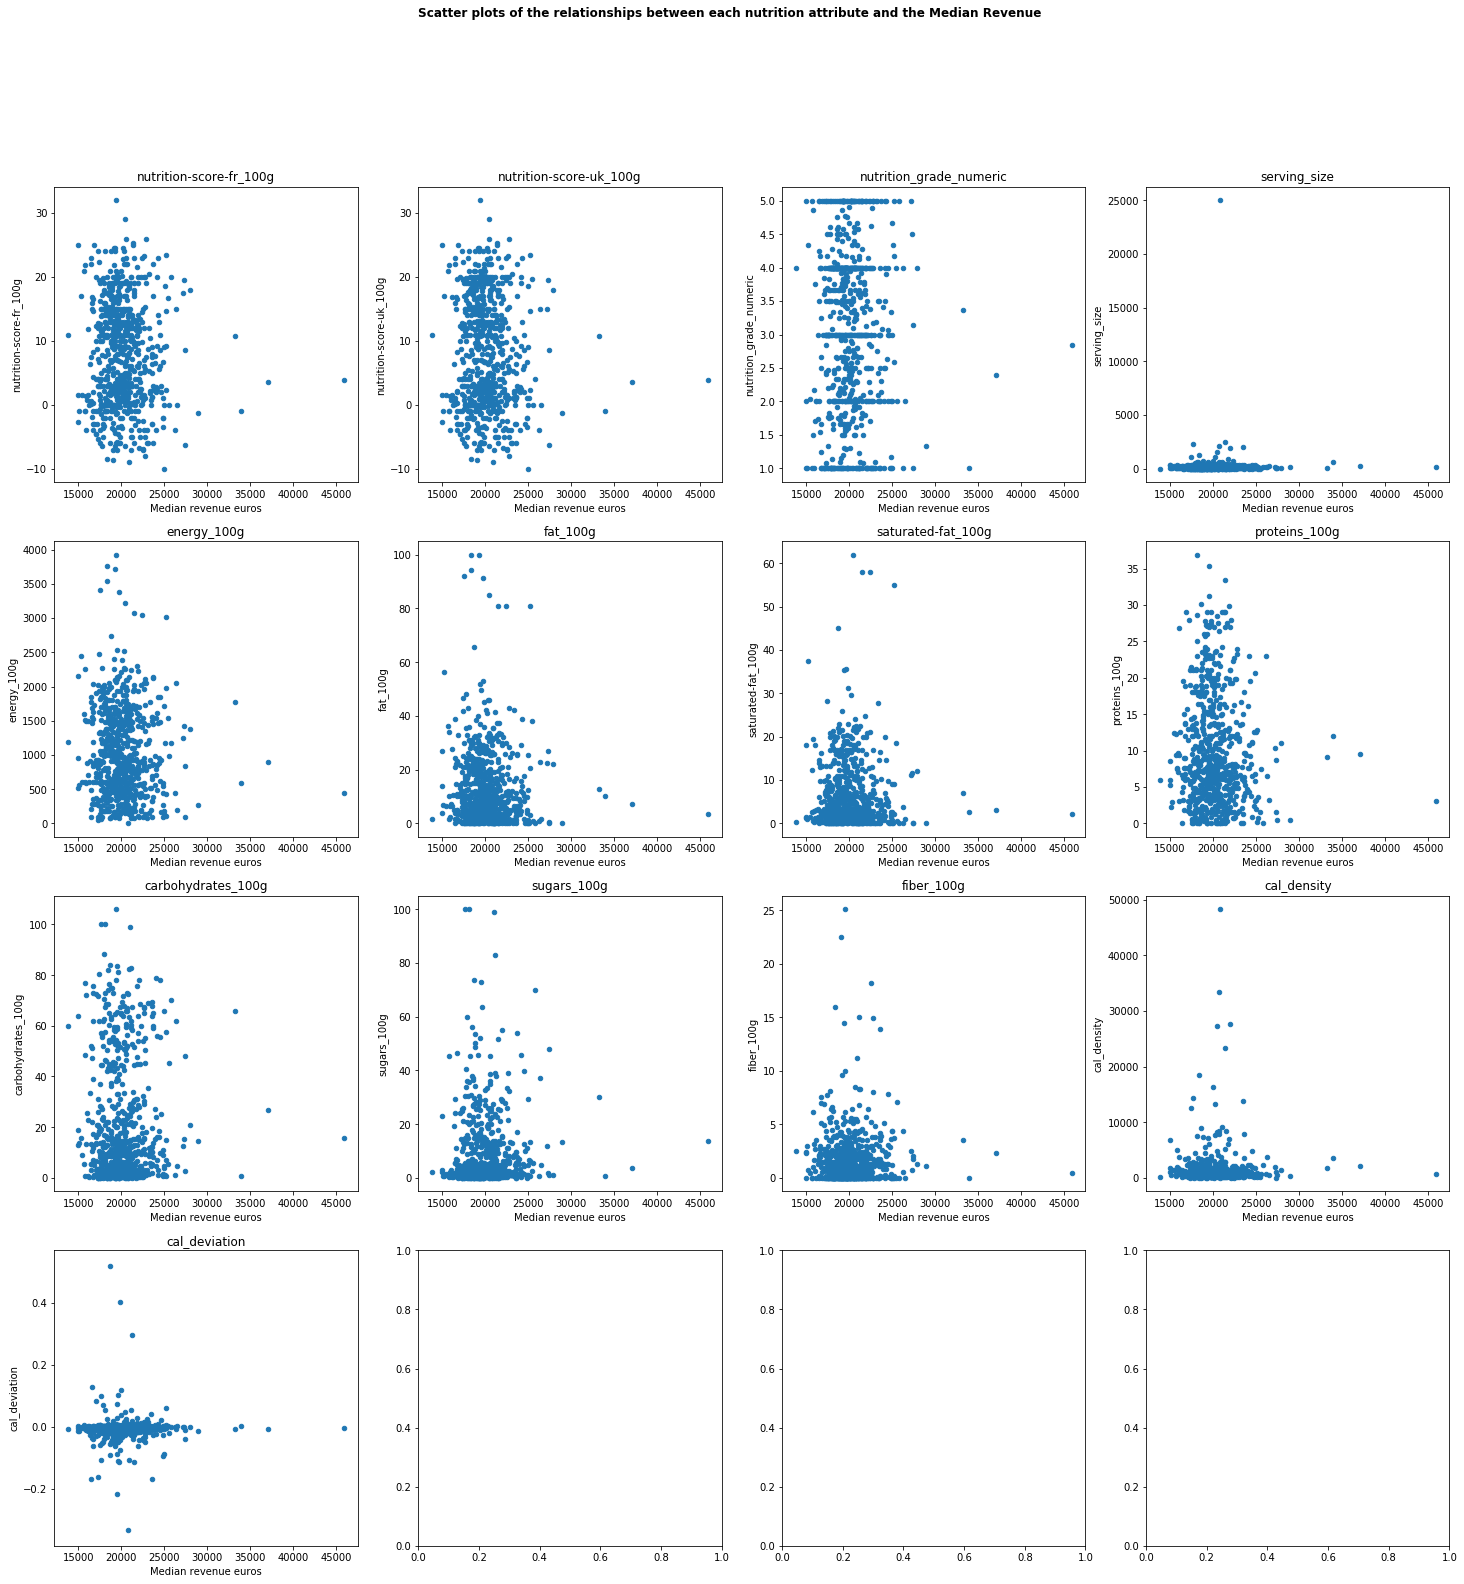

In [71]:
plot_scatter(dataframe_city)

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


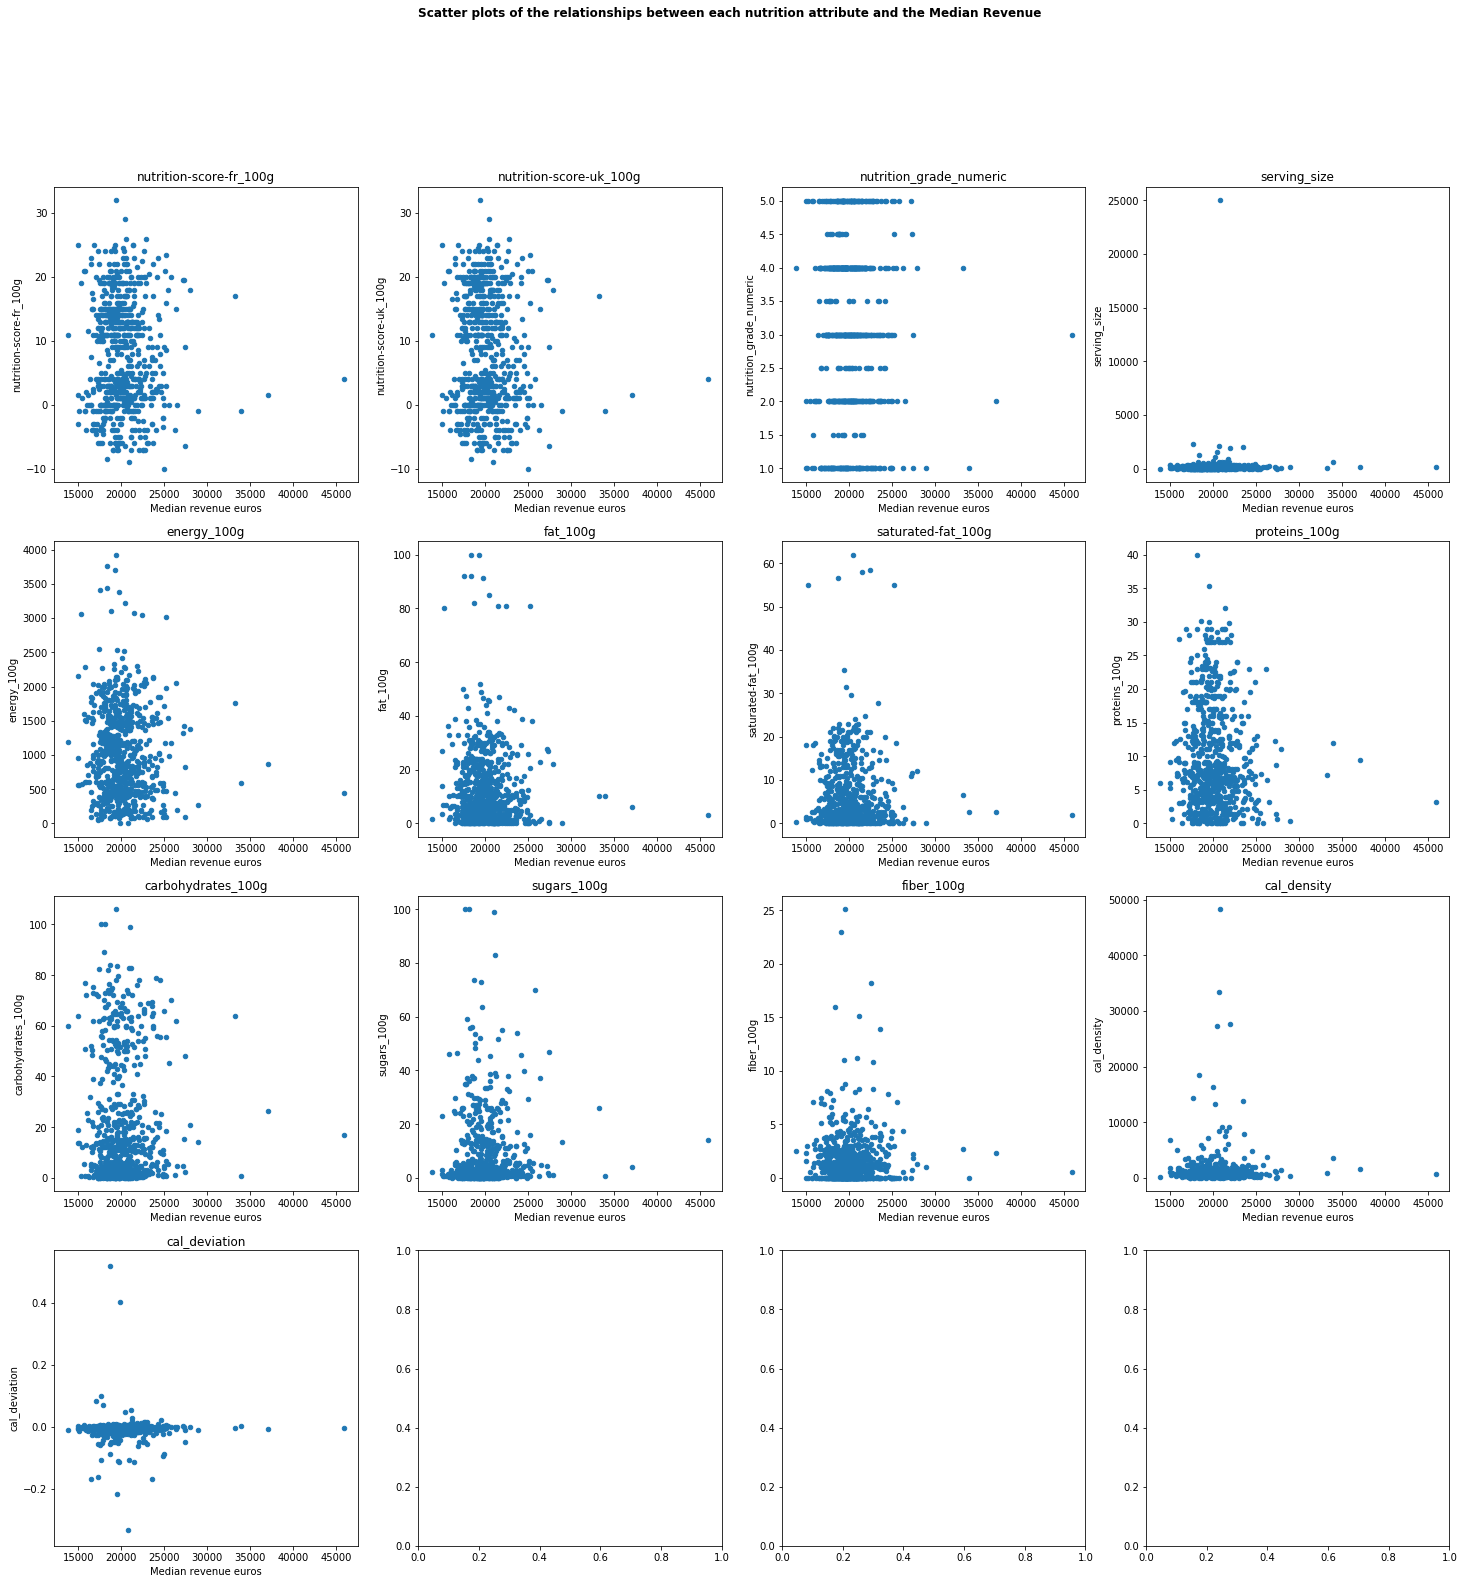

In [72]:
plot_scatter(dataframe_city_med)

**2. Arrondissements**

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


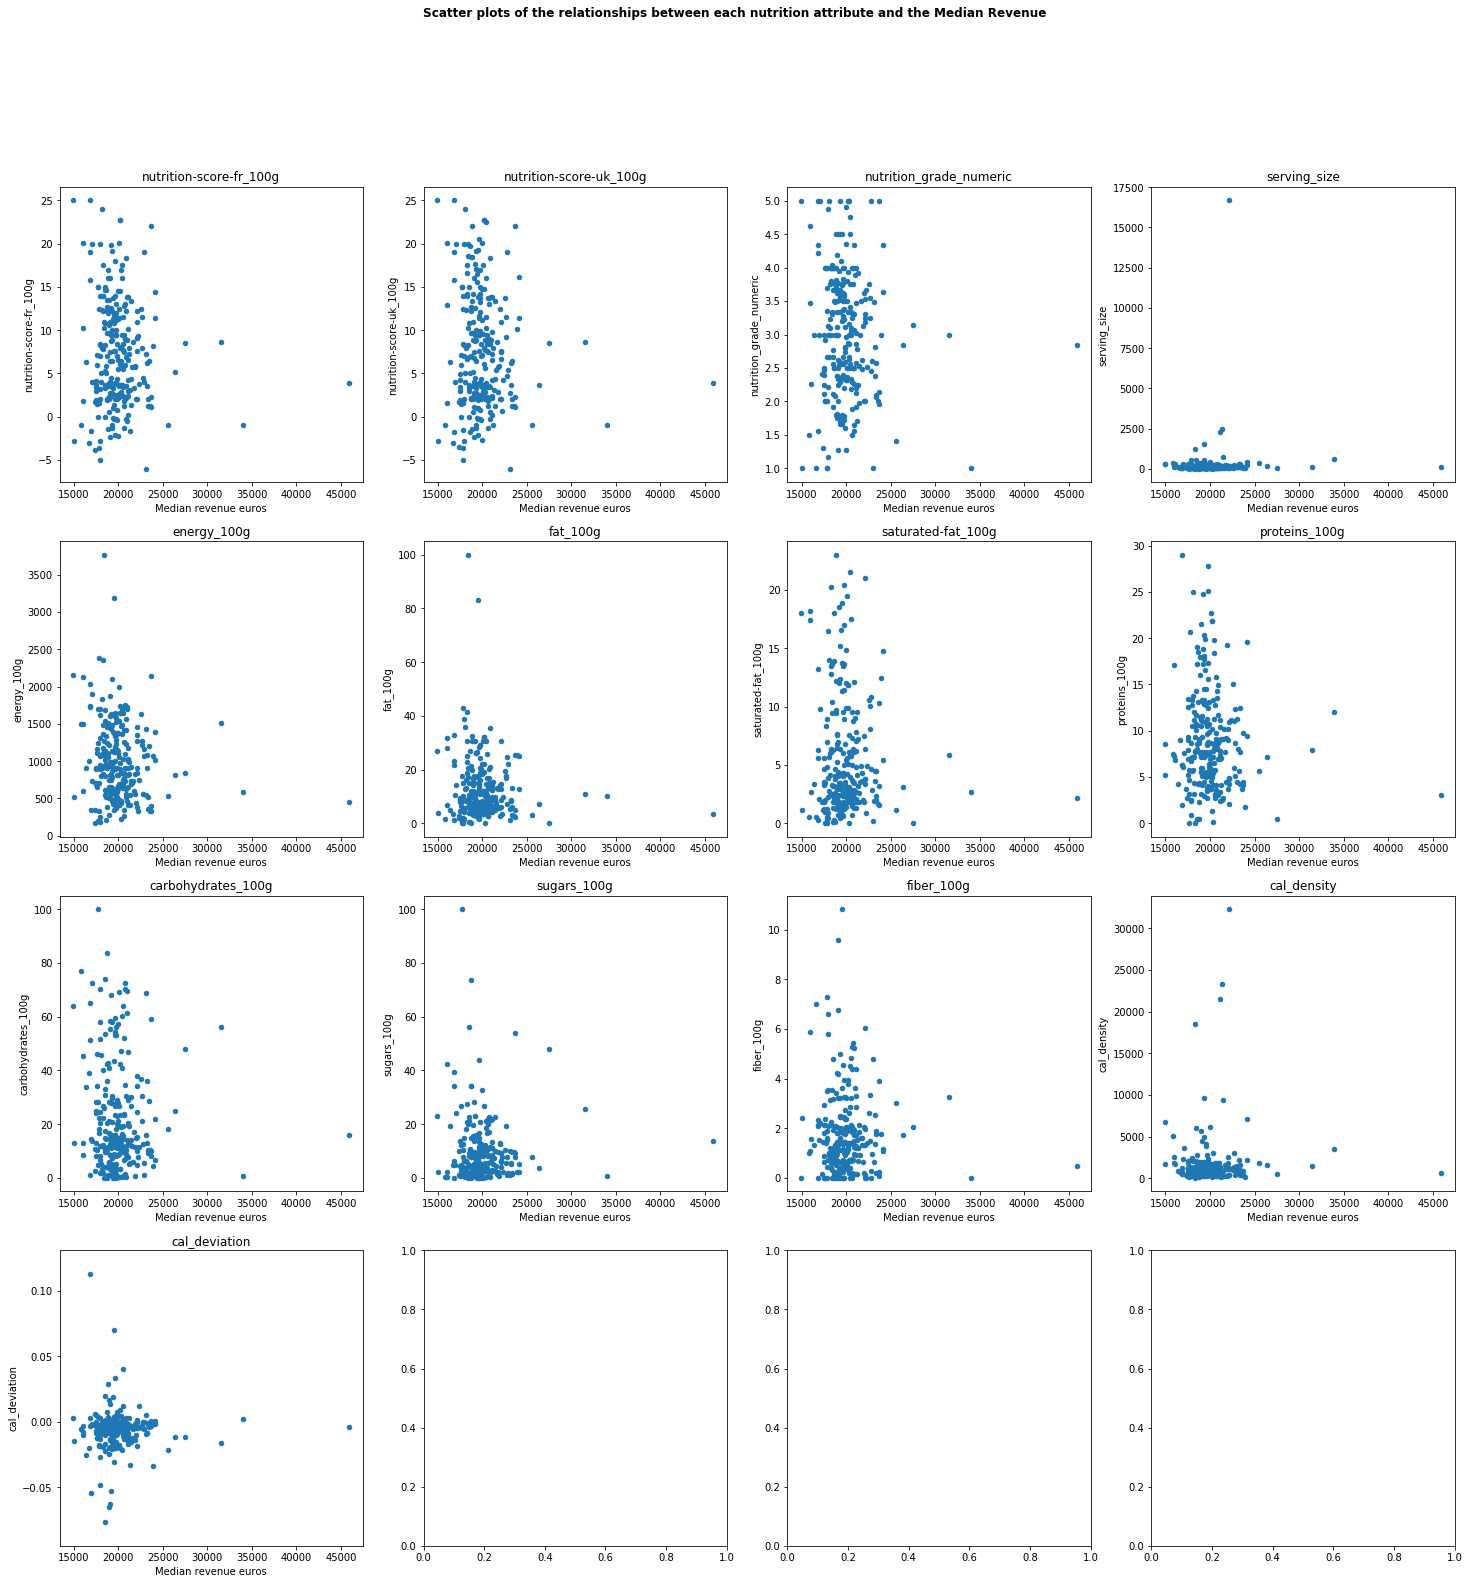

In [73]:
plot_scatter(dataframe_arr)

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


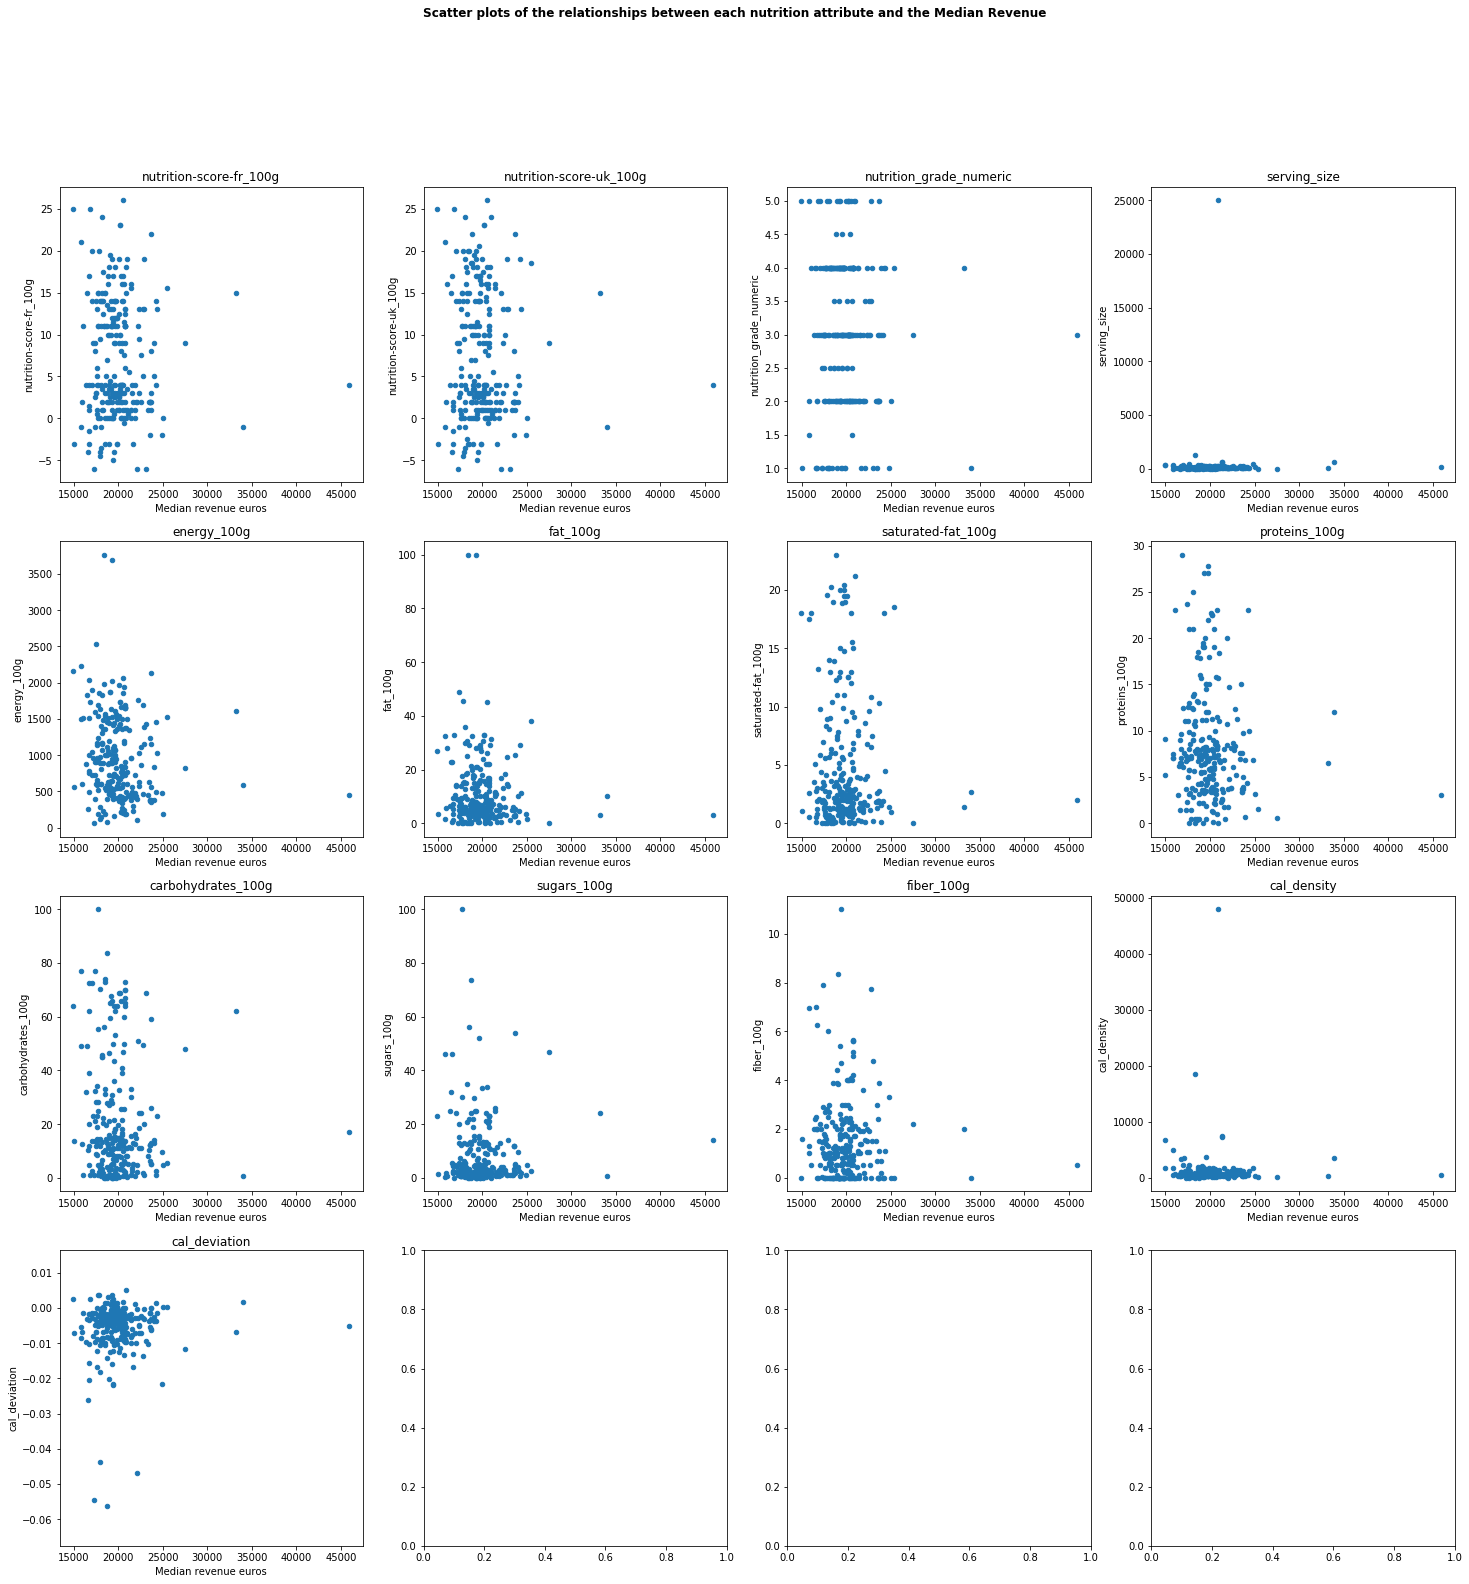

In [74]:
plot_scatter(dataframe_arr_med)

**3. Departments**

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


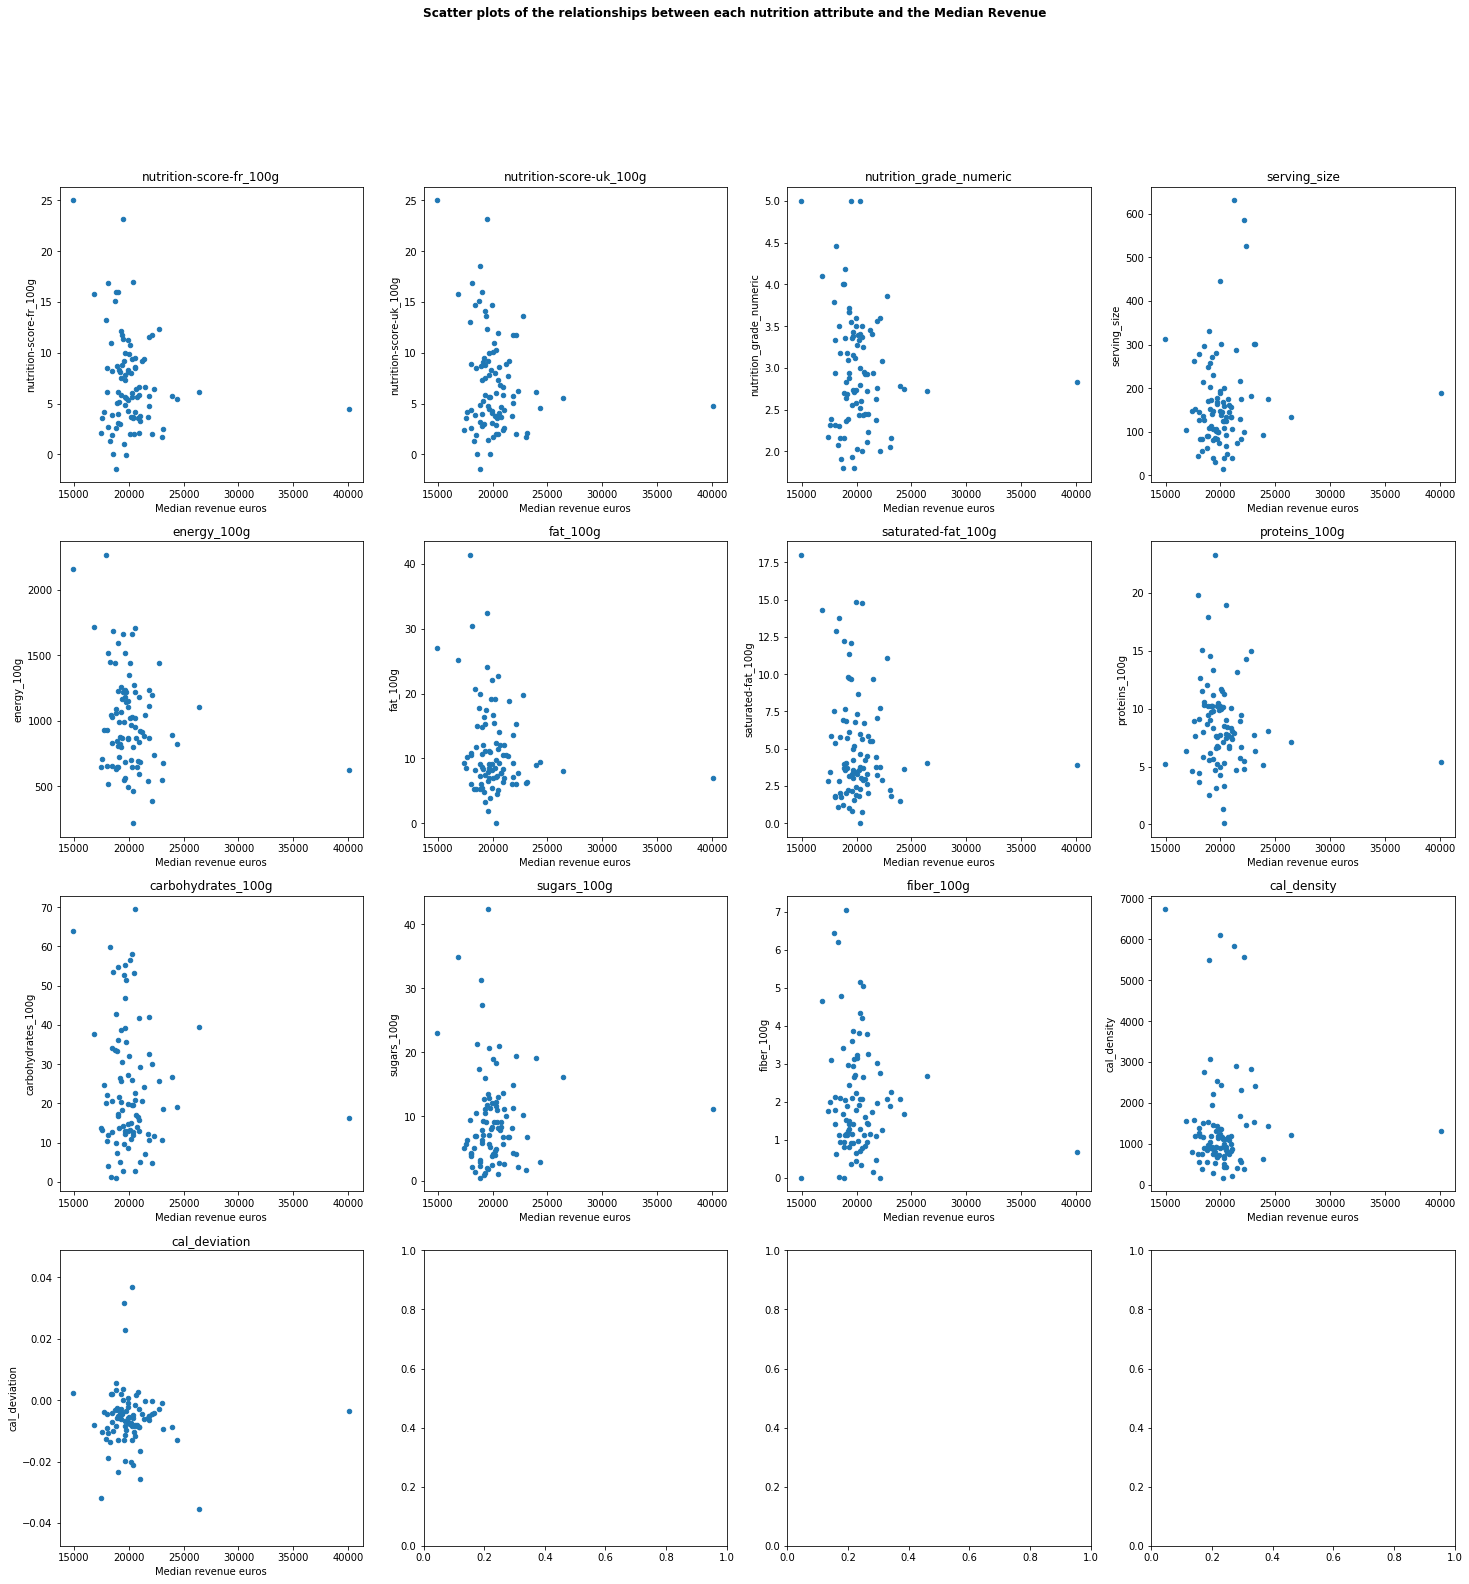

In [75]:
plot_scatter(dataframe_dep)

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


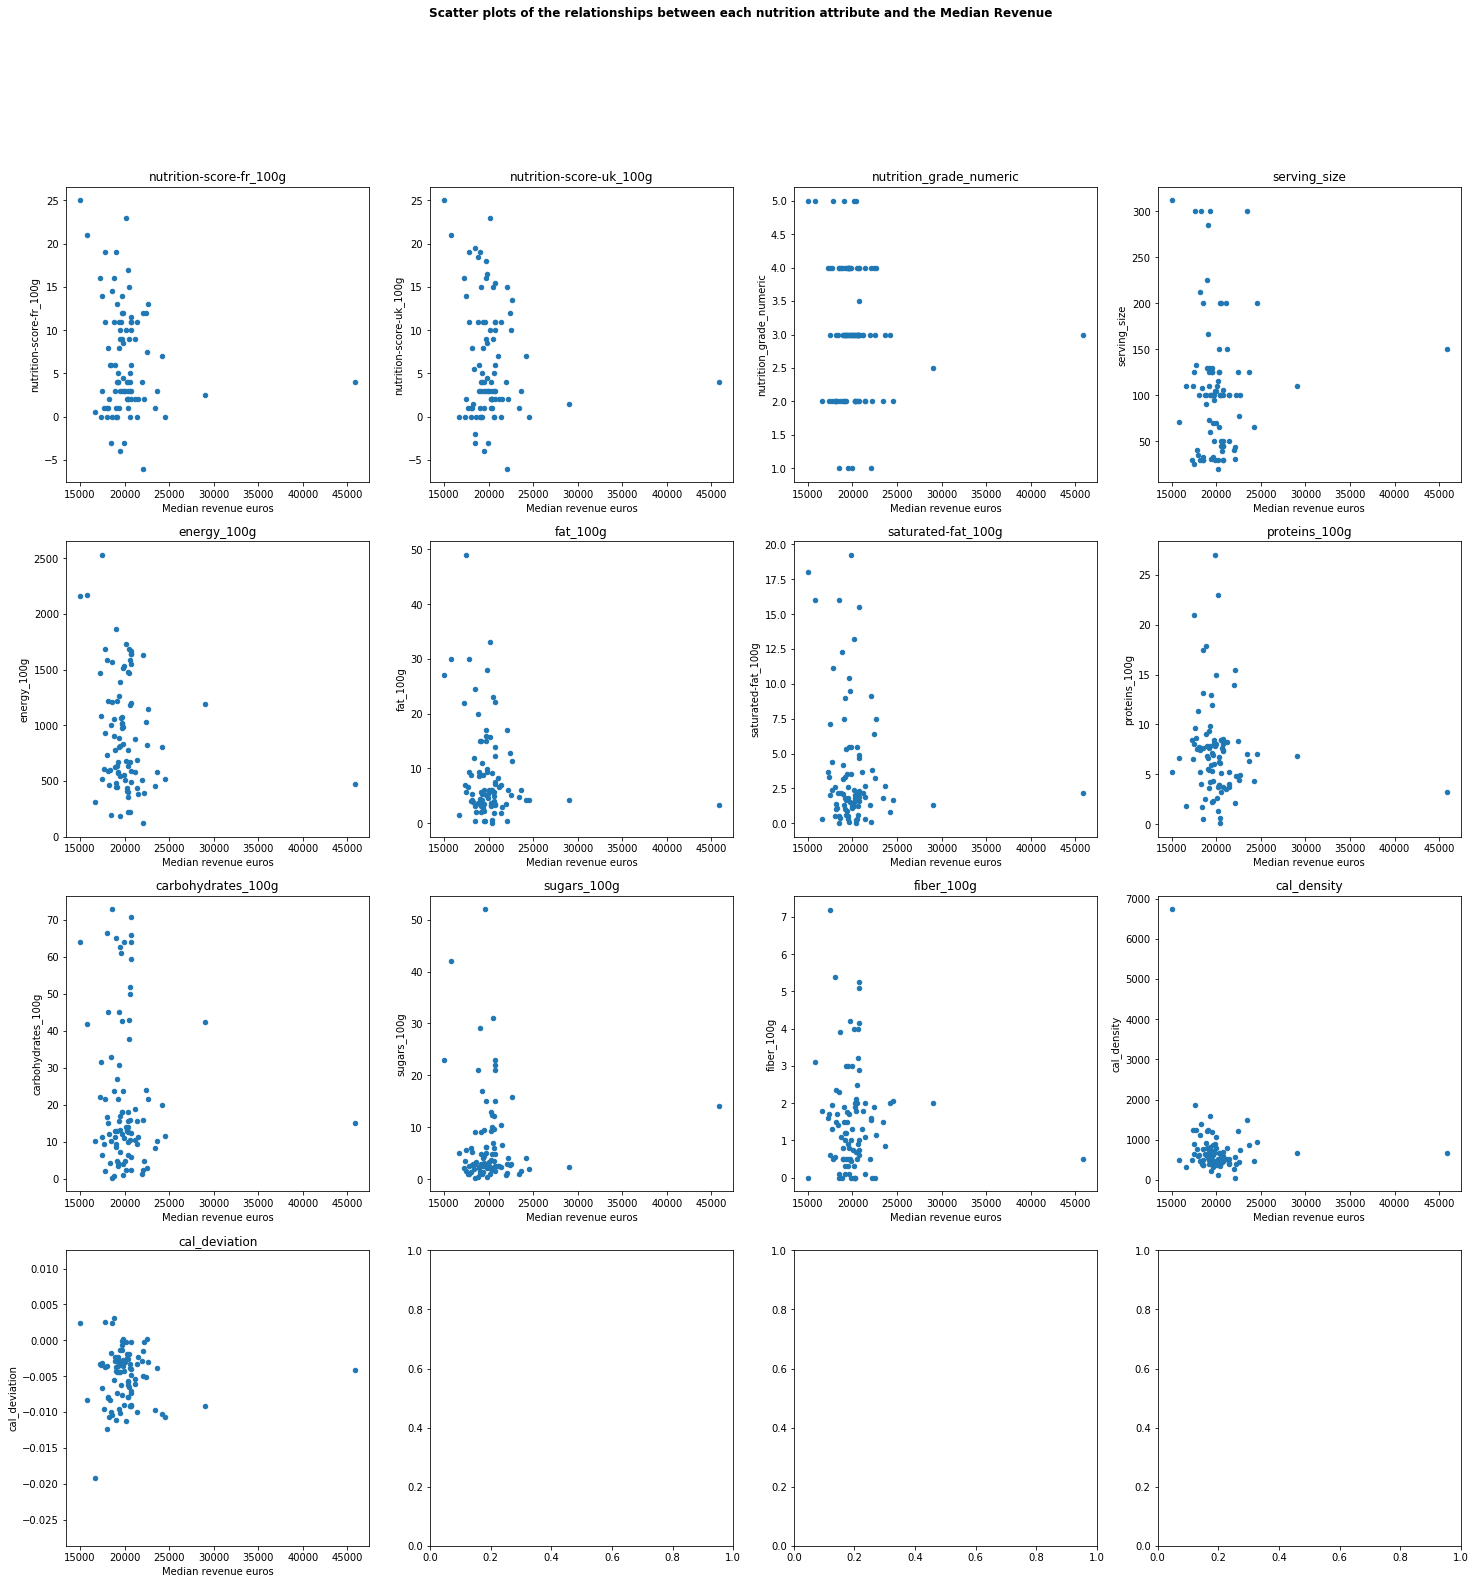

In [76]:
plot_scatter(dataframe_dep_med)

**4. Regions**

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


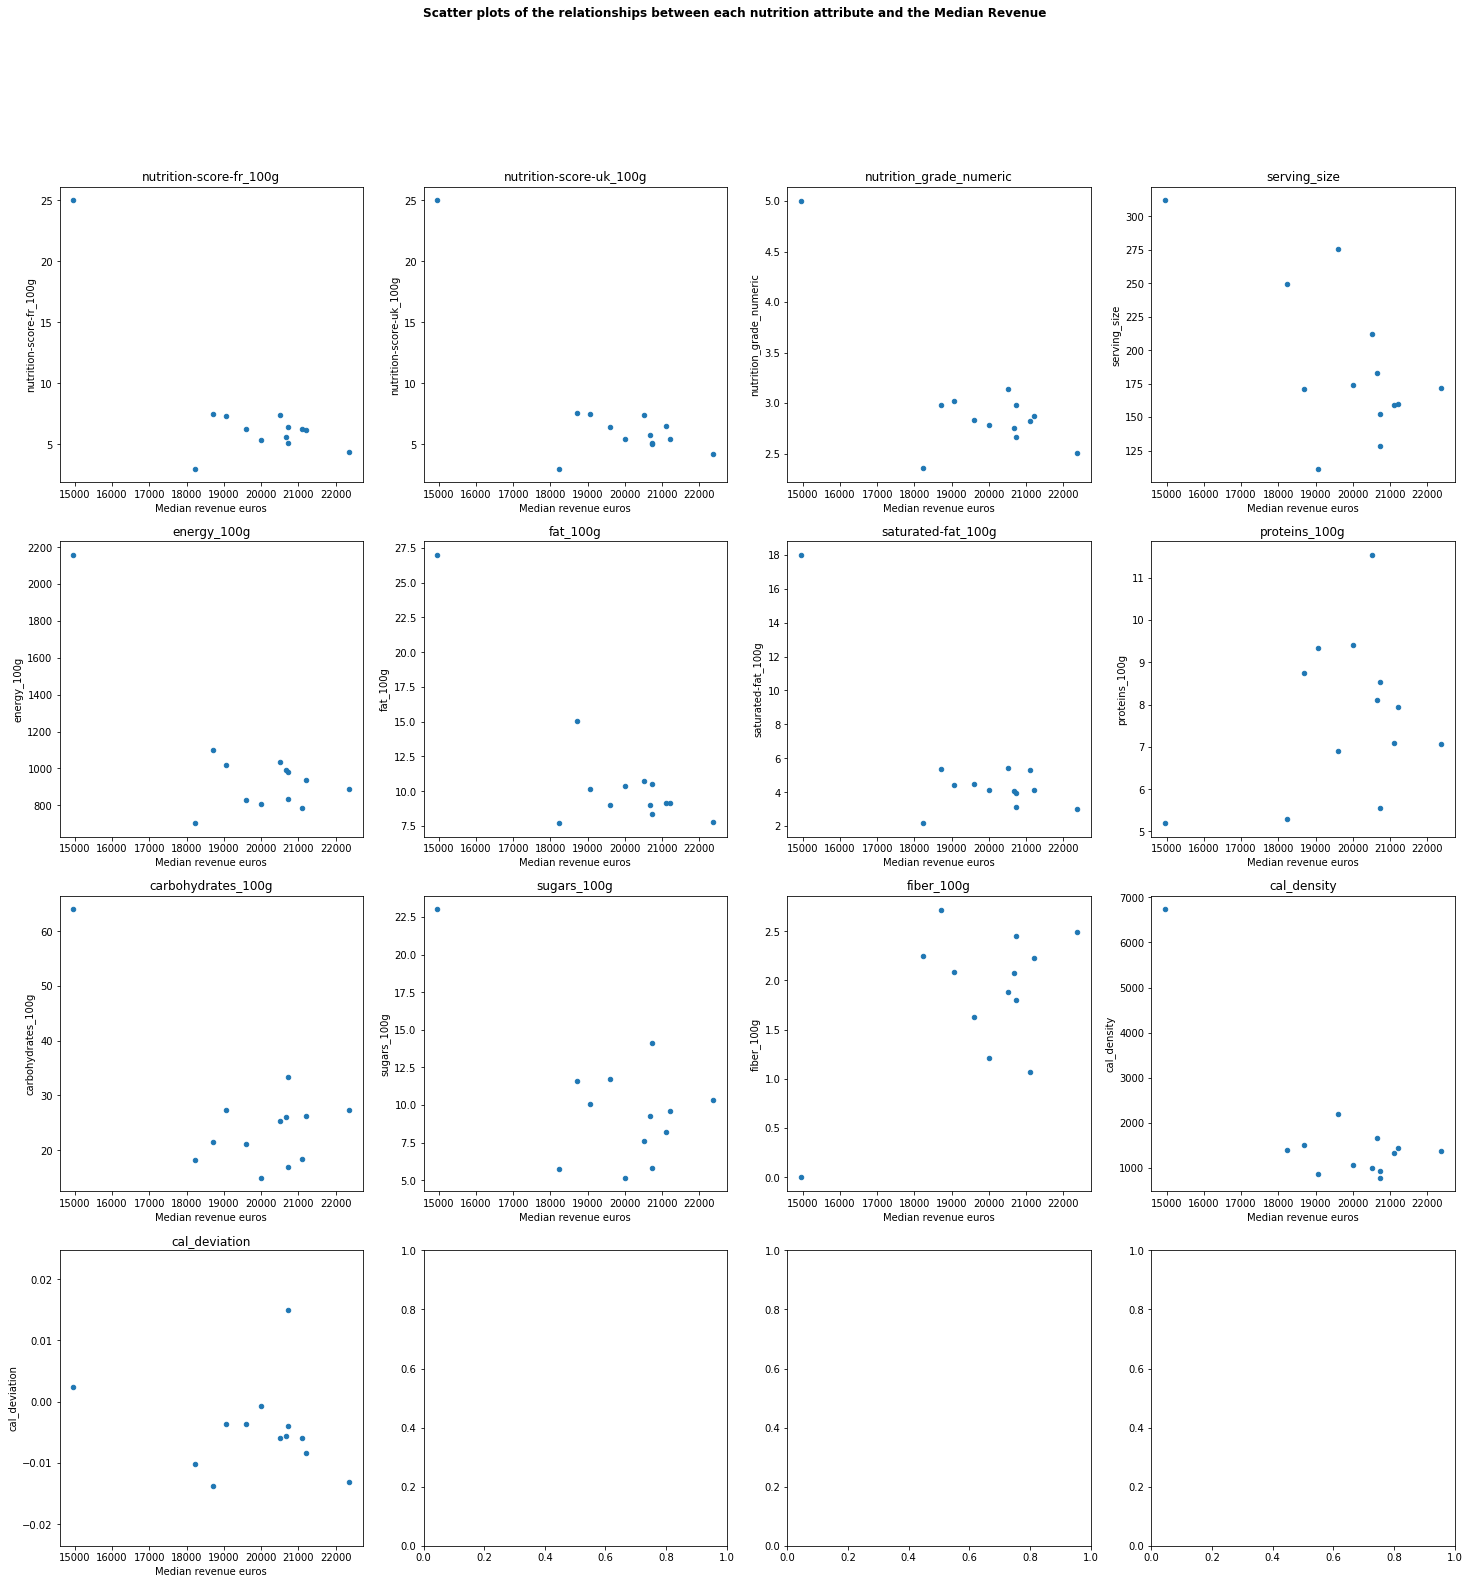

In [77]:
plot_scatter(dataframe_reg)

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


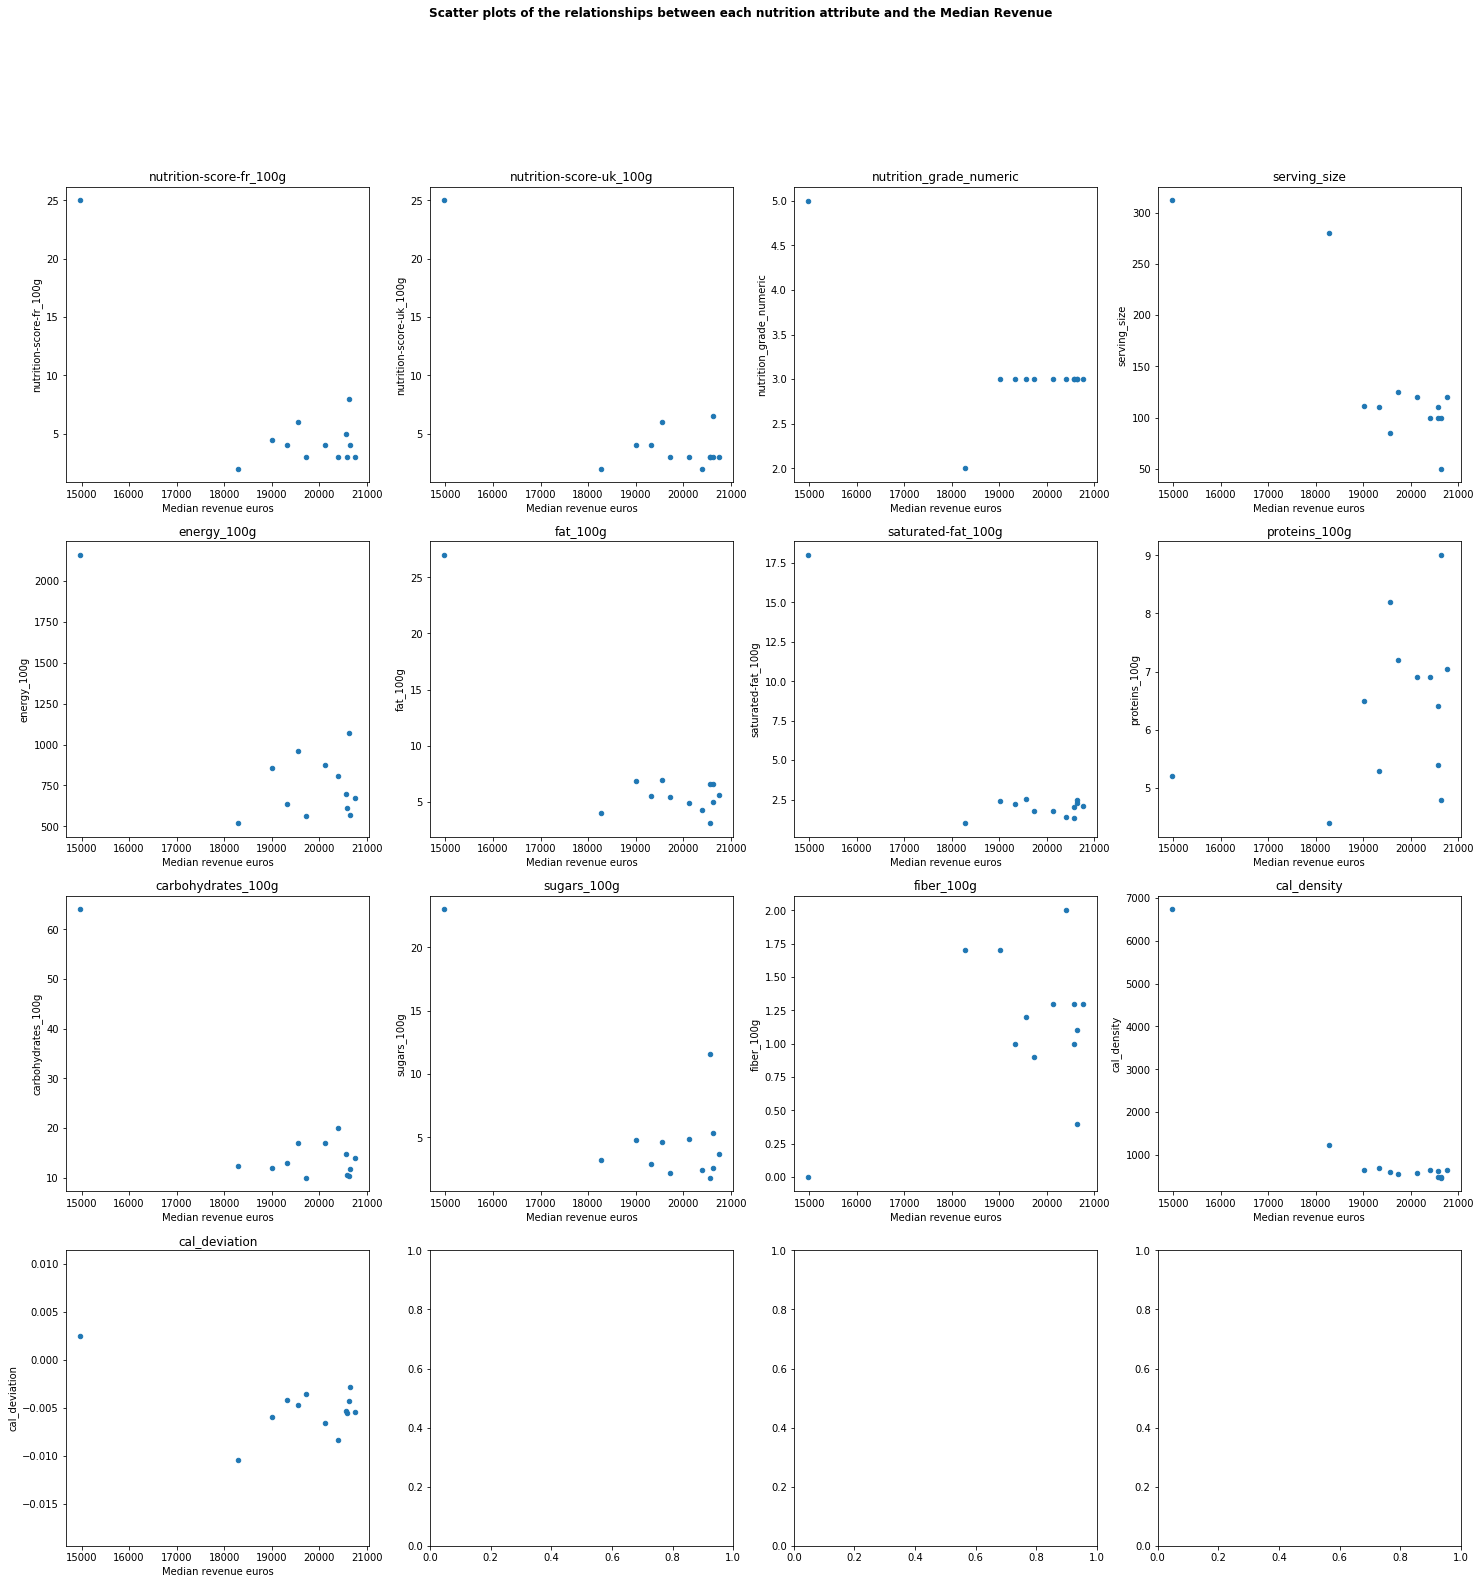

In [78]:
plot_scatter(dataframe_reg_med)

In [126]:
def cluster(df, eps, min_samples):
    X = StandardScaler().fit_transform(df)

    # Compute DBSCAN
    db = DBSCAN(eps=0.3, min_samples=10).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    print("Silhouette Coefficient: %0.3f"
          % metrics.silhouette_score(X, labels))

    # Plot result
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()
    
    return labels

Estimated number of clusters: 1
Estimated number of noise points: 115
Silhouette Coefficient: 0.355


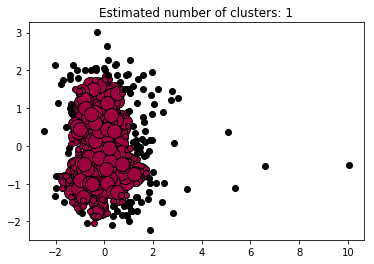

In [127]:
labels = cluster(dataframe_city[['Median revenue euros', 'nutrition-score-fr_100g']], 0.3, 1)

Estimated number of clusters: 1
Estimated number of noise points: 74
Silhouette Coefficient: 0.293


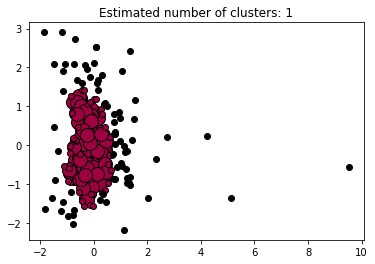

In [128]:
labels = cluster(dataframe_arr[['Median revenue euros', 'nutrition-score-fr_100g']], 3, 10)

Estimated number of clusters: 2
Estimated number of noise points: 65
Silhouette Coefficient: -0.163


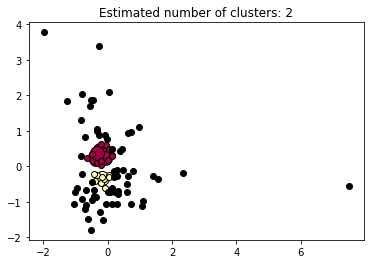

In [129]:
labels = cluster(dataframe_dep[['Median revenue euros', 'nutrition-score-fr_100g']], 3, 2)

In [130]:
labels = cluster(dataframe_reg[['Median revenue euros', 'energy_100g']], 100, 1)

Estimated number of clusters: 0
Estimated number of noise points: 13


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

# 6. Correlation analysis 

In [131]:
def plot_corr_matrix(df1, df2, geography):
    corr1 = df1.corr()
    corr2 = df2.corr()
    names1 = list(corr1.columns)
    names2 = list(corr1.columns)
    # plot correlation matrix
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 5.1))
    f.suptitle("Correlation matrix for " + geography, y=1.45, fontweight="bold")
    
    cax1 = ax1.matshow(corr1, vmin=-1, vmax=1)
    ticks1 = np.arange(0, len(names1), 1)
    ax1.set_xticks(ticks1)
    ax1.set_yticks(ticks1)
    ax1.set_xticklabels(names1)
    ax1.set_yticklabels(names1)
    ax1.tick_params(axis='x', labelrotation=90)
    ax1.set_title('Mean', y=1.45)
    
    cax2 = ax2.matshow(corr2, vmin=-1, vmax=1)
    ticks2 = np.arange(0, len(names2), 1)
    ax2.set_xticks(ticks2)
    ax2.set_yticks(ticks2)
    ax2.set_xticklabels(names2)
    ax2.set_yticklabels(names2)
    ax2.tick_params(axis='x', labelrotation=90)
    ax2.set_title('Median', y=1.45)
    
    f.colorbar(cax1)
    plt.show()

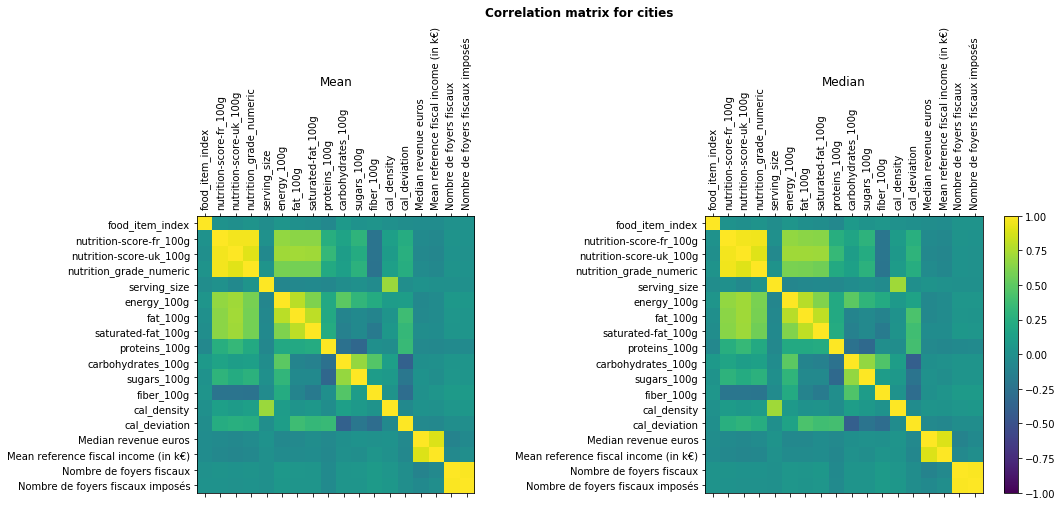

In [132]:
plot_corr_matrix(dataframe_city, dataframe_city_med, "cities")

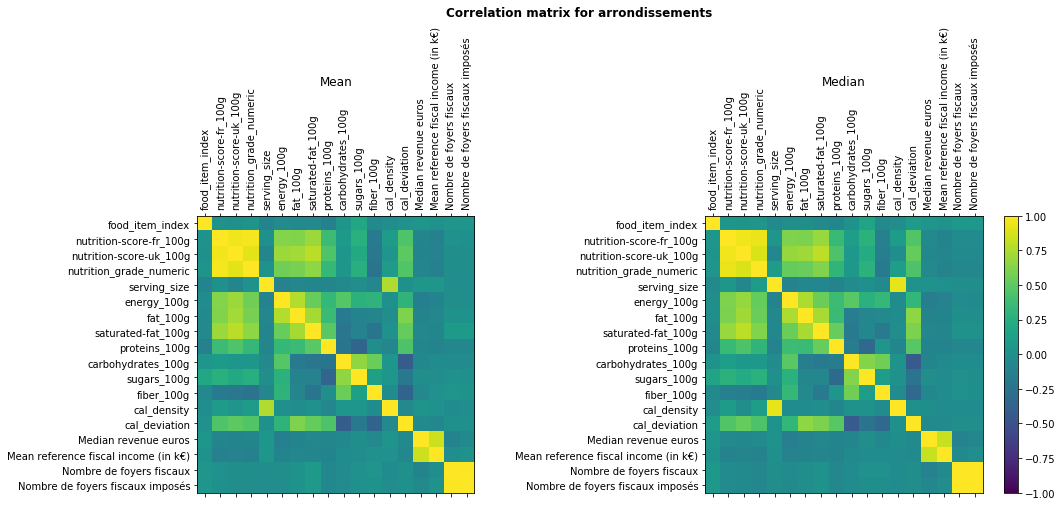

In [133]:
plot_corr_matrix(dataframe_arr, dataframe_arr_med, "arrondissements")

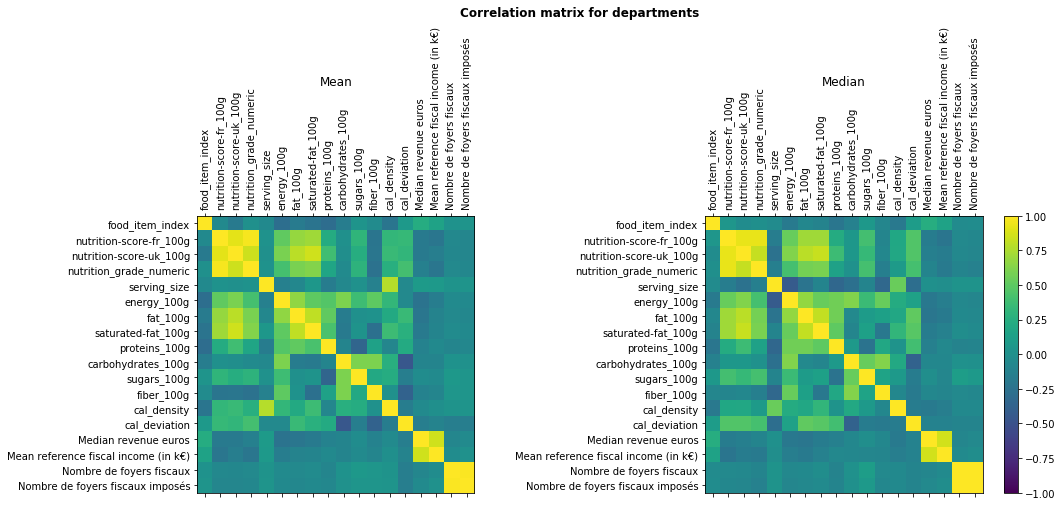

In [134]:
plot_corr_matrix(dataframe_dep, dataframe_dep_med, "departments")

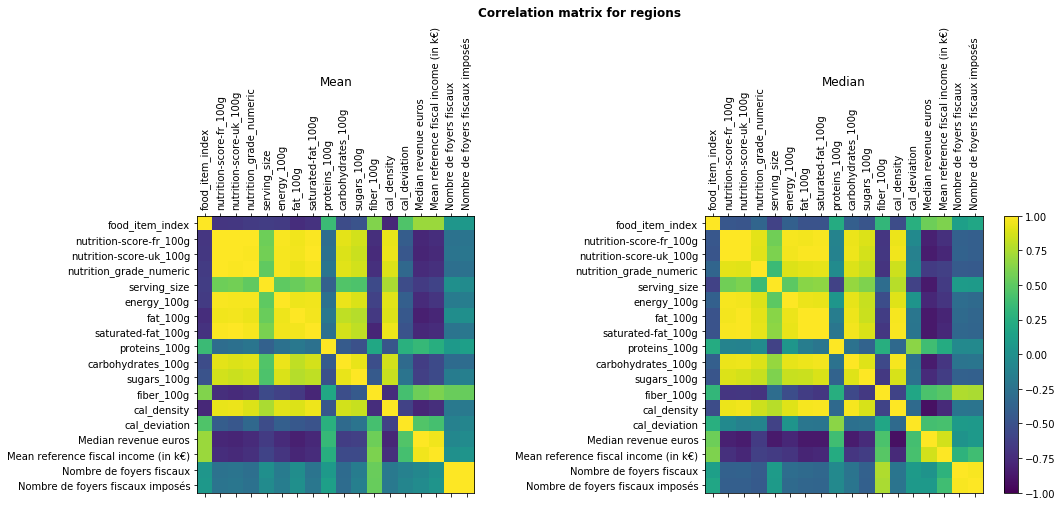

In [135]:
plot_corr_matrix(dataframe_reg, dataframe_reg_med, "regions")

Hooray, we found something at the region level! Let's see more closely how significant it is:

In [136]:
revenue_cols = ['Median revenue euros', 'Mean reference fiscal income (in k€)']
nutri_cols = ['nutrition-score-fr_100g', 'nutrition-score-uk_100g',
              'nutrition_grade_numeric', 'serving_size', 'energy_100g', 'fat_100g',
              'saturated-fat_100g', 'proteins_100g', 'carbohydrates_100g','sugars_100g', 
              'fiber_100g', 'cal_density', 'cal_deviation']

In [161]:
def pearson_pval_df(df):
    for col1 in revenue_cols:
        print(col1, ':')
        for col2 in nutri_cols:
            r, p = stats.pearsonr(df[col2], df[col1])
            p = p*4
            if p < 0.05:
                color = 'green'
            else:
                color = 'red'
            print(colored('{:<40}{:<16}{:<28.3f}{:<10}{:<30.3f}'.format(col2, 'Pearson coeff', r, 'p-value', p), color))
        print('\n')

In [162]:
pearson_pval_df(dataframe_reg)

Median revenue euros :
nutrition-score-fr_100g                 Pearson coeff   -0.778                      p-value   0.007                         
nutrition-score-uk_100g                 Pearson coeff   -0.792                      p-value   0.005                         
nutrition_grade_numeric                 Pearson coeff   -0.756                      p-value   0.011                         
serving_size                            Pearson coeff   -0.650                      p-value   0.064                         
energy_100g                             Pearson coeff   -0.750                      p-value   0.012                         
fat_100g                                Pearson coeff   -0.824                      p-value   0.002                         
saturated-fat_100g                      Pearson coeff   -0.772                      p-value   0.008                         
proteins_100g                           Pearson coeff   0.340                       p-value   1.022   

In [163]:
pearson_pval_df(dataframe_reg_med)

Median revenue euros :
nutrition-score-fr_100g                 Pearson coeff   -0.815                      p-value   0.003                         
nutrition-score-uk_100g                 Pearson coeff   -0.850                      p-value   0.001                         
nutrition_grade_numeric                 Pearson coeff   -0.653                      p-value   0.062                         
serving_size                            Pearson coeff   -0.858                      p-value   0.001                         
energy_100g                             Pearson coeff   -0.775                      p-value   0.007                         
fat_100g                                Pearson coeff   -0.864                      p-value   0.001                         
saturated-fat_100g                      Pearson coeff   -0.863                      p-value   0.001                         
proteins_100g                           Pearson coeff   0.389                       p-value   0.757   

From the mean dataframe, the columns for which the correlation with the Median revenue is significant (i.e. the corresponding p-value is below 0.05) are:

* nutrition-score-fr_100g          
* nutrition-score-uk_100g  
* nutrition_grade_numeric  
* serving_size             
* energy_100g              
* fat_100g                 
* saturated-fat_100g   
* sugars_100g
* cal_density       
* cal_deviation     

For all these columns, we have a negative correlation between each of them and the mean median revenue for the overall region. The Pearson coefficients are all below the -0.3 threshold that allows us to claim that there is a correlation. 
The Pearson coefficients are actually below -0.5 for each of these columns.

The negative correlation is more significant for sugars, fat, saturated fat, the nutrition scores and the calory density (coefficient around **-0.7 / -0.8**).

For the median dataframe, we can observe the same tendencies. 

# 7. Vizzzzzzzzz

We only found an actual relationship for regions so this is what we're gonna viz.

First we have to reset the indexes.

In [55]:
dataframe_reg.reset_index(inplace=True)
dataframe_reg_med.reset_index(inplace=True)

Then we have to transform the 'Region' column from int to string and add a 0 if the region number only has one character.

In [56]:
dataframe_reg['Region'] = dataframe_reg['Region'].apply(lambda x : str(x))
dataframe_reg['Region'] = dataframe_reg['Region'].apply(lambda x : '0'+x if len(x) == 1 else x)

dataframe_reg_med['Region'] = dataframe_reg['Region'].apply(lambda x : str(x))
dataframe_reg_med['Region'] = dataframe_reg['Region'].apply(lambda x : '0'+x if len(x) == 1 else x)

Region borders

In [57]:
# geojson: https://github.com/gregoiredavid/france-geojson
reg_borders = json.load(open("../data/raw/regions-avec-outre-mer.geojson"))

And now the viz:

In [58]:
for column in ['nutrition_grade_numeric', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g']:
    map_nutrition = folium.Map(location=[46.5, 2.3], tiles='cartodbpositron', zoom_start=6)
    scale = np.linspace(np.min(dataframe_reg[column]), np.max(dataframe_reg[column]), 6)
    map_nutrition.choropleth(geo_data=reg_borders, 
                           data=dataframe_reg, 
                           columns=['Region', column],
                           key_on='feature.properties.code',
                           legend_name=column,
                           threshold_scale=list(scale),
                           fill_color='OrRd',fill_opacity=0.7, line_opacity=0.2,
                      )

    map_nutrition.save("../data/processed/map_{}.html".format(column))
    display(HTML("<a href='../data/processed/map_{0}.html' target='_blank'>{0}</a>".format(column)))

In [59]:
map_revenue = folium.Map(location=[46.5, 2.3], tiles='cartodbpositron', zoom_start=6)
scale = np.linspace(np.min(dataframe_reg['Median revenue euros']), np.max(dataframe_reg['Median revenue euros']), 6)
map_revenue.choropleth(geo_data=reg_borders, 
                       data=dataframe_reg, 
                       columns=['Region', 'Median revenue euros'],
                       key_on='feature.properties.code',
                       legend_name='Median revenue euros',
                       threshold_scale=list(scale),
                       fill_color='OrRd',fill_opacity=0.7, line_opacity=0.2,
                  )

map_revenue.save("../data/processed/map_{}.html".format('Median revenue euros'))
display(HTML("<a href='../data/processed/map_{0}.html' target='_blank'>{0}</a>".format('Median revenue euros')))

# Old analysis

In [60]:
dummy_df = dataframe[['food_item_index', 'nutrition_grade_numeric', 'Median revenue euros', 'City name', 
                      'custom_arrondissement_code', 'Department', 'Region']]

In [61]:
def analyse_for_area(area_column, area_name, revenue_column, limit=10):
    """Performs the analysis for a type of area (city, region, ...)
    
    Arguments:
    -----------
    area_column: string
        Name of the column for the wanted type of area.
    area_name: string
        Name of the wanted type of area.
    limit: int
        Number of areas to consider.
    revenue_column: string
        Name of the revenue-related column to consider.
    """
    # group the products by area
    freq_df = dummy_df.groupby(area_column).count().sort_values(by=['food_item_index'], ascending=False)
    # take the limit areas with the most available data
    first_ten = list(freq_df[:limit].index)
    # initial dataset limited to the above selected areas
    rev_df = dummy_df[dummy_df[area_column].apply(lambda x: x in first_ten)]
    dummies = pd.get_dummies(rev_df, columns=['nutrition_grade_numeric'])
    
    list_dummy_grades = ['nutrition_grade_numeric_0', 'nutrition_grade_numeric_1',
                         'nutrition_grade_numeric_2', 'nutrition_grade_numeric_3',
                         'nutrition_grade_numeric_4', 'nutrition_grade_numeric_5']
    # compute the frequency of each grade per area
    frequency = dummies.groupby(area_column).sum()[list_dummy_grades]
    revenue = dummies.groupby(area_column).mean()[['food_item_index', revenue_column]]
    example = frequency.join(revenue, how='inner').sort_values(by=[revenue_column], ascending=False)
    
    # take the two most different areas
    area_1 = example.iloc[[0]][list_dummy_grades]
    area_2 = example.iloc[[limit - 1]][list_dummy_grades]
    
    # plot the distribution for each of the selected area
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
    fig.suptitle("Distribution of the nutrition grades' frequencies for 2 {}".format(area_name),
                 y=1.08, fontweight="bold")
    area_1.plot.bar(ax=ax1)
    ax1.set_title("{} 1: {} = {} €".format(area_name, revenue_column,
                                           list(example.iloc[[0]][revenue_column].values)[0]))
    area_2.plot.bar(ax=ax2)
    ax2.set_title("{} 2: {} = {} €".format(area_name, revenue_column, 
                                           list(example.iloc[[limit - 1]][revenue_column].values)[0]))
    plt.show()
    
    print("Mean: ")
    print(rev_df.groupby(area_column).mean().sort_values(
        by=revenue_column, ascending=False
    ).iloc[[0, limit - 1]]['nutrition_grade_numeric'])
    
    print("Median: ")
    print(rev_df.groupby(area_column).median().sort_values(
        by=revenue_column, ascending=False
    ).iloc[[0, limit - 1]]['nutrition_grade_numeric'])
    
    # Find median values for nutrition grade and revenue and plot them
    rev_grade = dummy_df.groupby(area_column).median()
    rev_grade.plot.scatter(x=revenue_column, y='nutrition_grade_numeric', figsize=(10, 6))
    rev_grade.boxplot(column=[revenue_column], by=['nutrition_grade_numeric'], vert=False, figsize=(10, 6))
    
    # Find ares that have at least 30 products within it
    nb_products = dummy_df.groupby(area_column).count()[['food_item_index']]
    nb_products = nb_products[nb_products['food_item_index'] > 30]
    list(nb_products.index)
    dummy_sup_30 = dummy_df[dummy_df[area_column].apply(lambda x : x in list(nb_products.index))]
    rev_grade_sup_30 = dummy_sup_30.groupby(area_column).median()
    
    # Plot
    rev_grade_sup_30.plot.scatter(x=revenue_column, y='nutrition_grade_numeric', figsize=(10, 6))
    rev_grade_sup_30.boxplot(column=[revenue_column], by=['nutrition_grade_numeric'], vert=False, figsize=(10, 6))

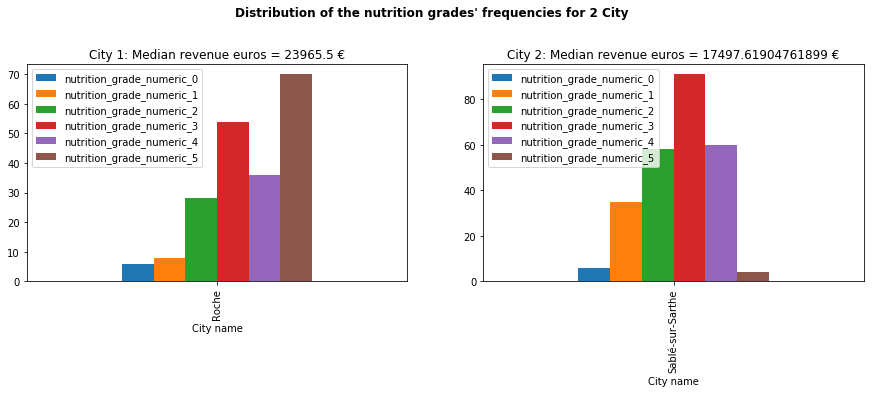

Mean: 
City name
Roche               3.564356
Sablé-sur-Sarthe    2.692913
Name: nutrition_grade_numeric, dtype: float64
Median: 
City name
Roche               4.0
Sablé-sur-Sarthe    3.0
Name: nutrition_grade_numeric, dtype: float64


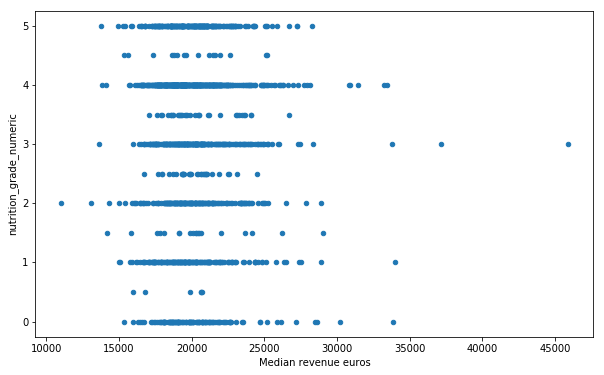

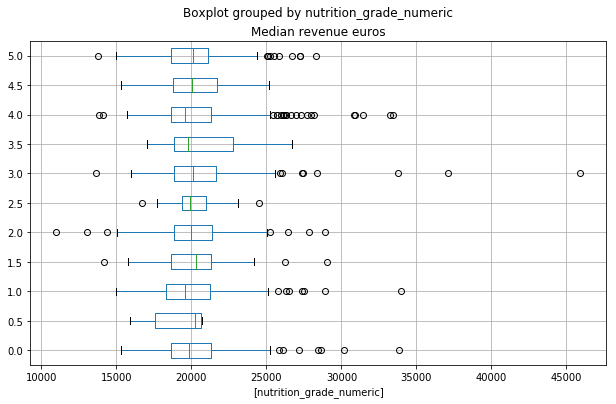

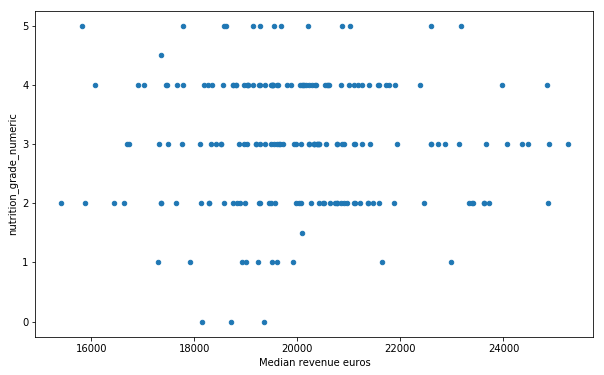

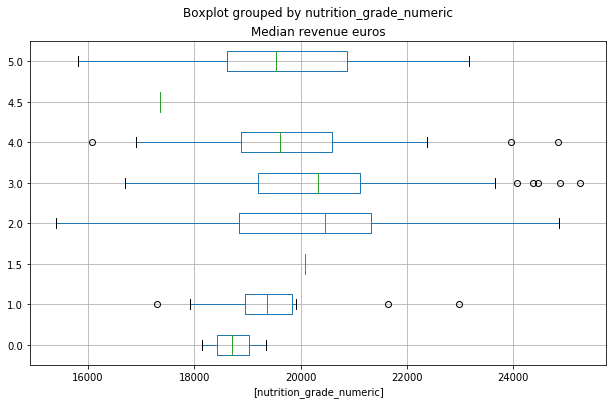

In [62]:
analyse_for_area('City name', 'City', 'Median revenue euros', 10)

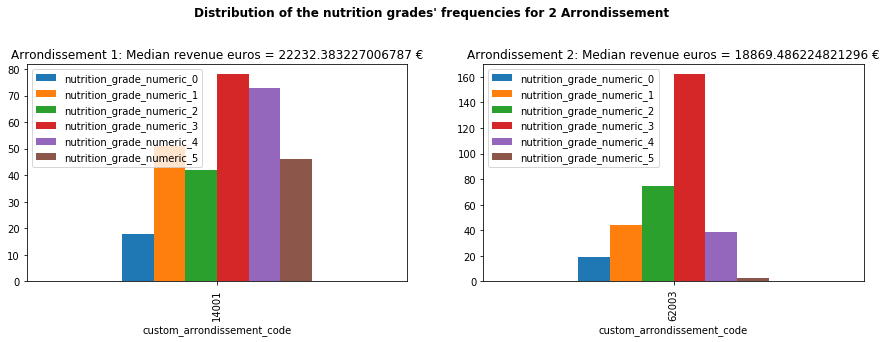

Mean: 
custom_arrondissement_code
14001    2.892857
62003    2.488304
Name: nutrition_grade_numeric, dtype: float64
Median: 
custom_arrondissement_code
14001    3.0
85002    3.0
Name: nutrition_grade_numeric, dtype: float64


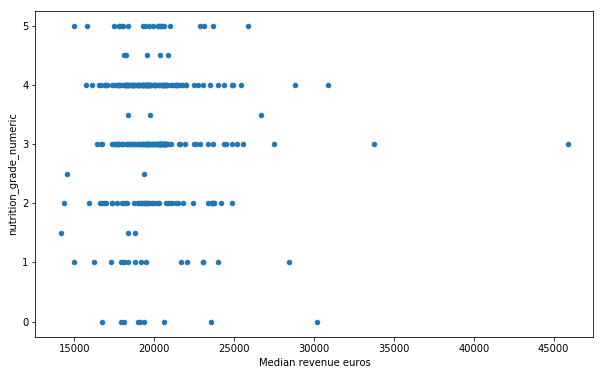

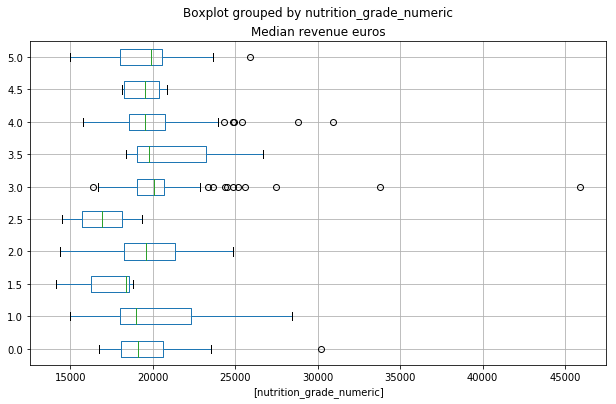

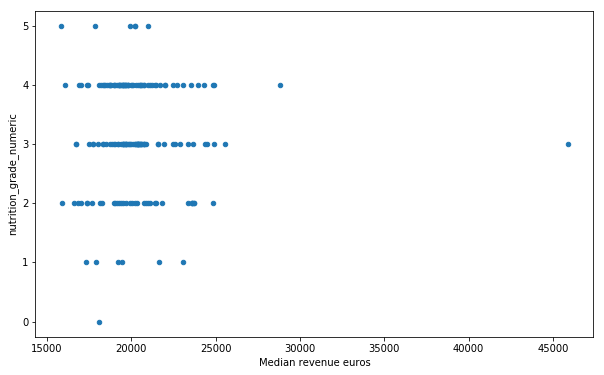

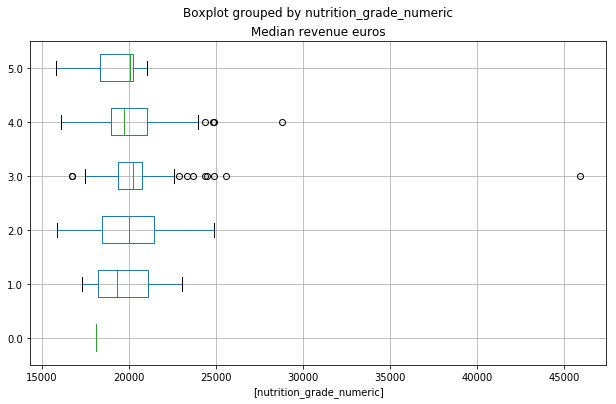

In [63]:
analyse_for_area('custom_arrondissement_code', 'Arrondissement', 'Median revenue euros', 10)

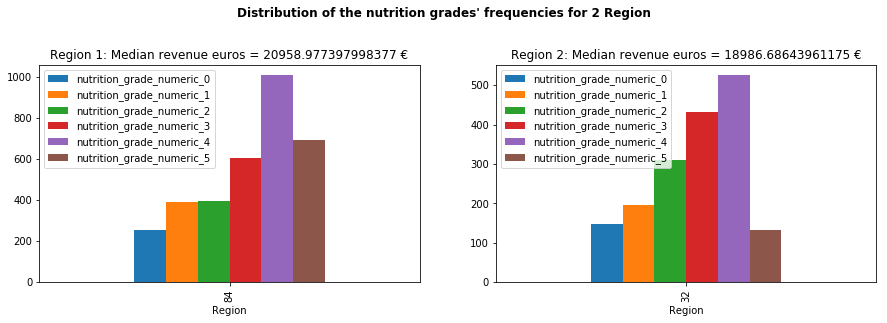

Mean: 
Region
84    3.135507
32    2.793696
Name: nutrition_grade_numeric, dtype: float64
Median: 
Region
27    3.0
76    4.0
Name: nutrition_grade_numeric, dtype: float64


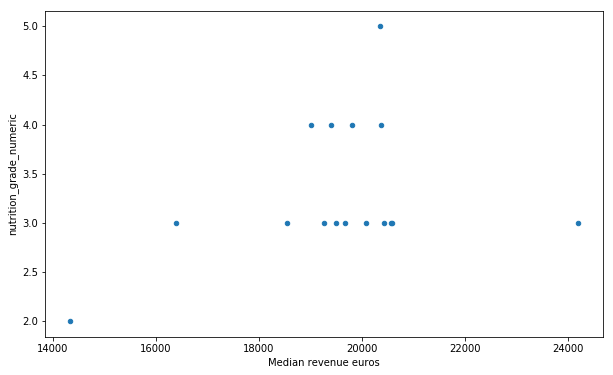

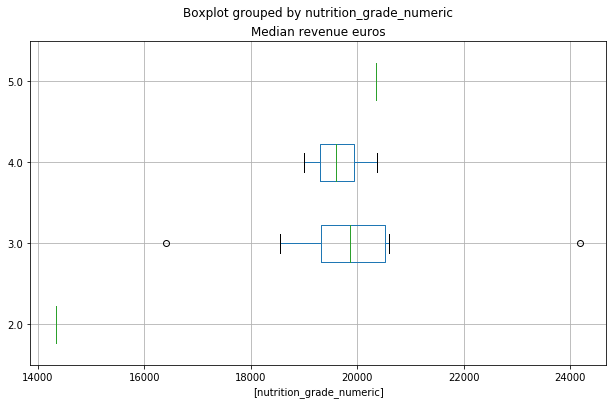

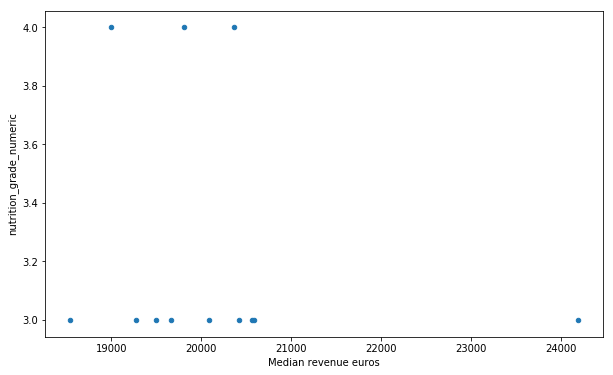

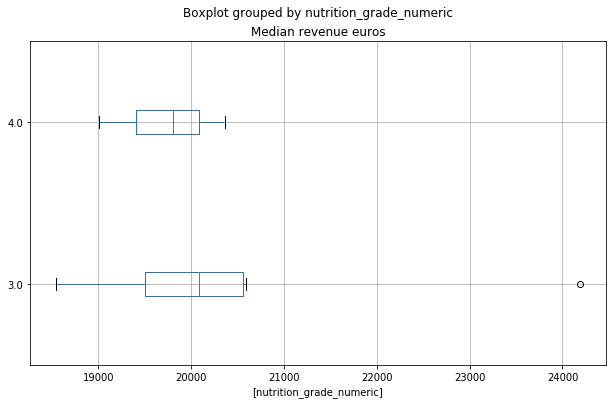

In [64]:
analyse_for_area('Region', 'Region', 'Median revenue euros', 10)

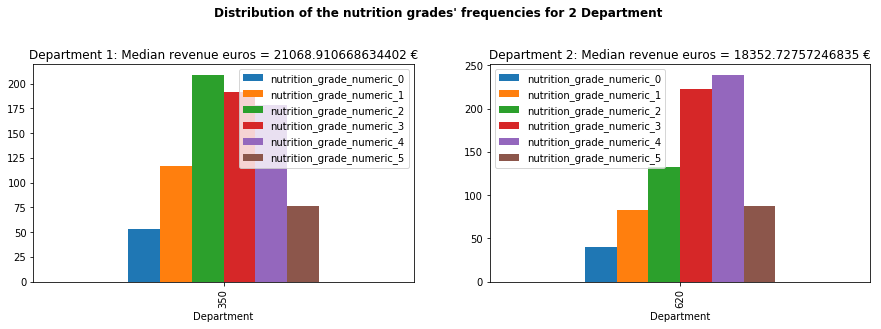

Mean: 
Department
350    2.670303
620    2.996269
Name: nutrition_grade_numeric, dtype: float64
Median: 
Department
350    3.0
720    3.0
Name: nutrition_grade_numeric, dtype: float64


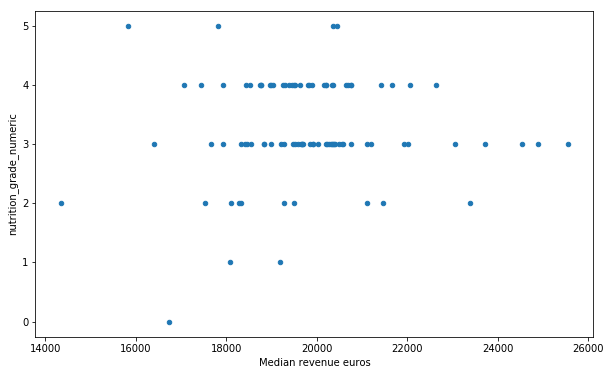

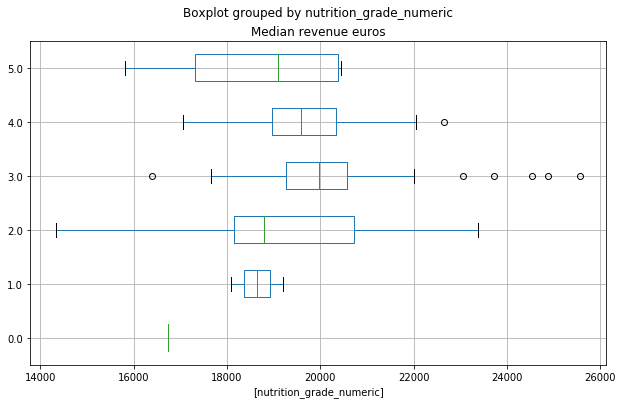

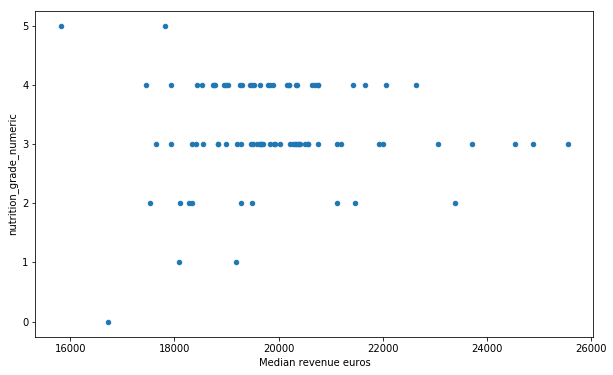

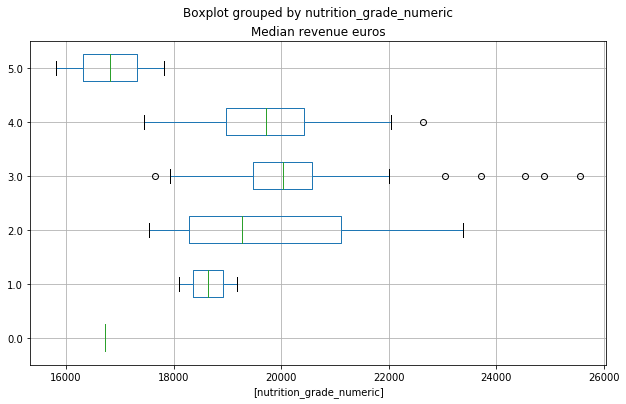

In [65]:
analyse_for_area('Department', 'Department', 'Median revenue euros', 10)

# 5. Study of correlations

# Correlation between income and "quality" of the available products

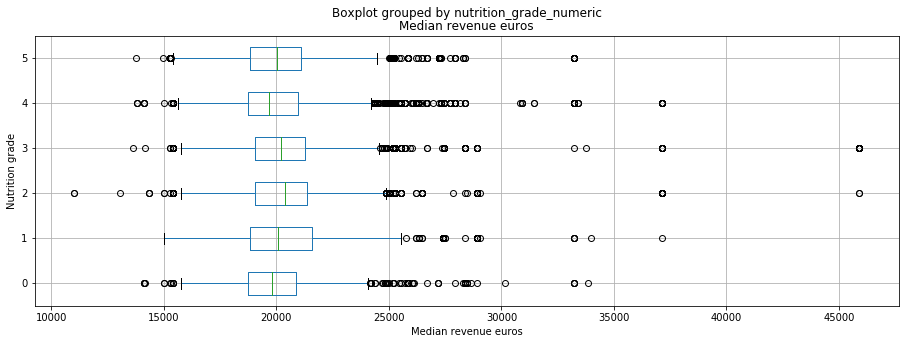

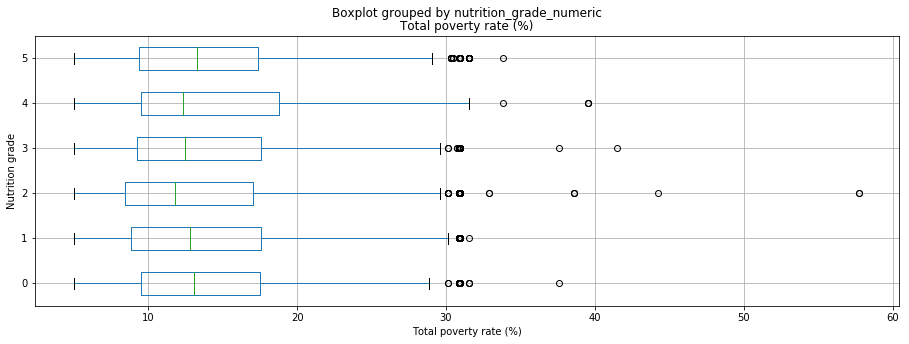

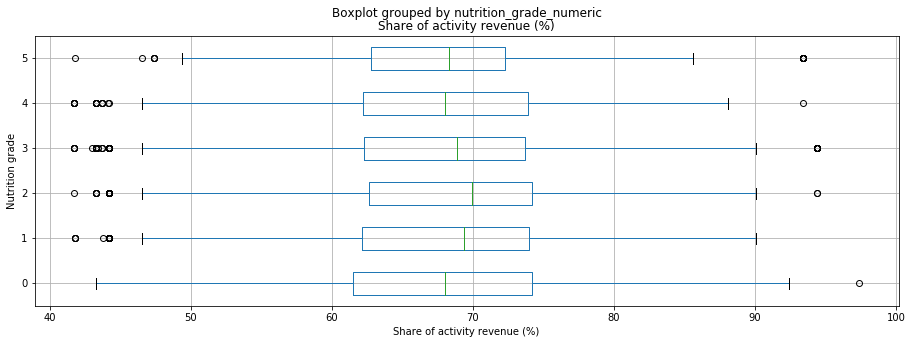

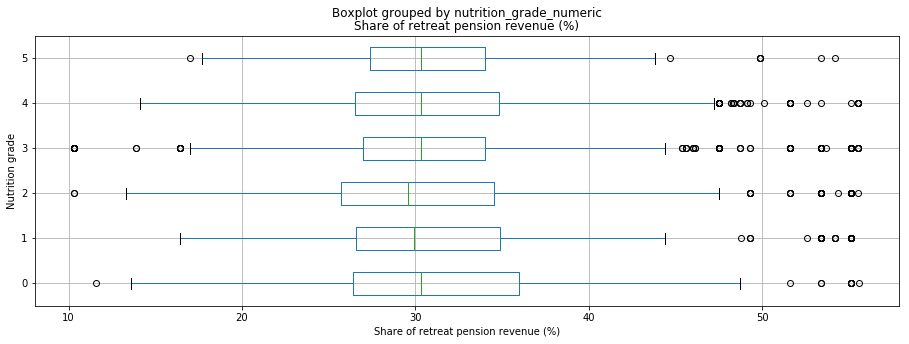

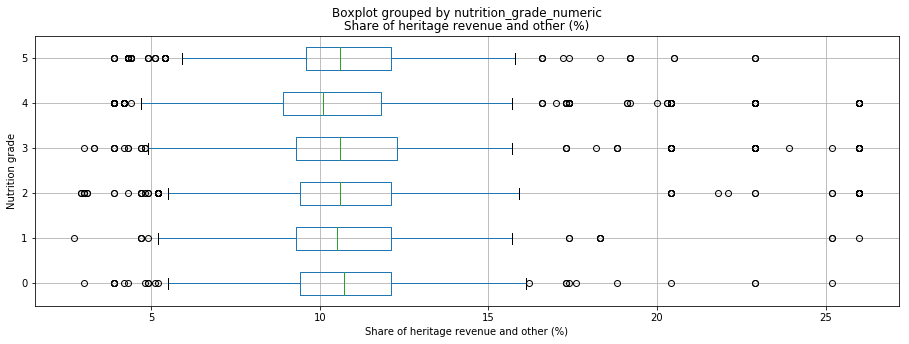

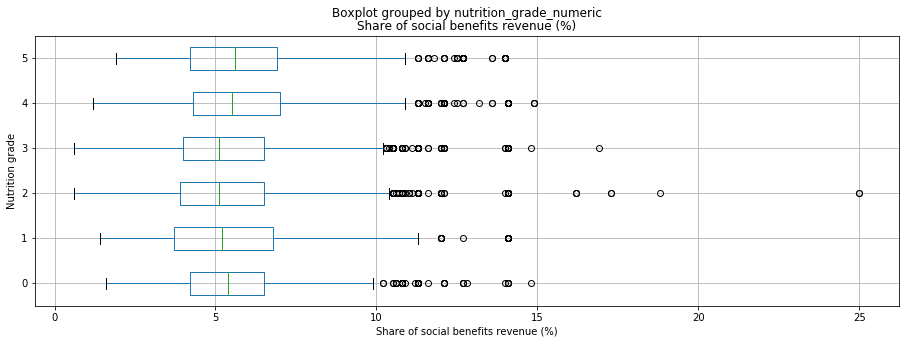

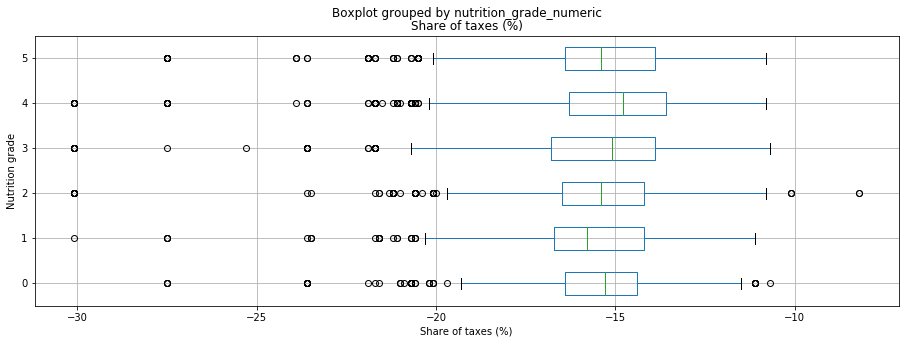

In [66]:
for column in ['Median revenue euros', 'Total poverty rate (%)',
       'Share of activity revenue (%)', 'Share of retreat pension revenue (%)',
       'Share of heritage revenue and other (%)',
       'Share of social benefits revenue (%)', 'Share of taxes (%)'
              ]:
    dataframe.boxplot(column=column, 
                  by='nutrition_grade_numeric', 
                  vert=False, figsize=(15, 5)
                 )
    plt.xlabel(column)#"Mean income of the purchase town (in €)")
    plt.ylabel("Nutrition grade")
    #plt.title("Distribution of the sold food items with regard to the median income of the purchase town.")
    plt.show()

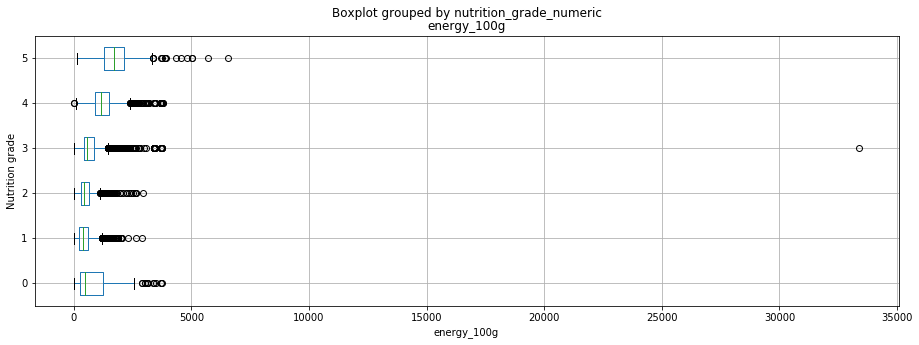

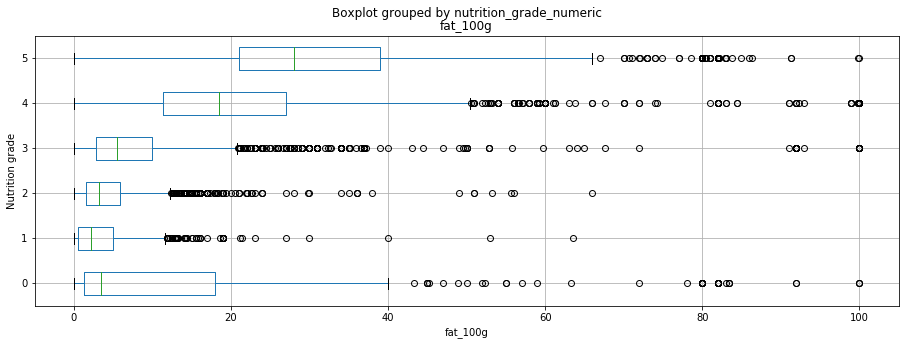

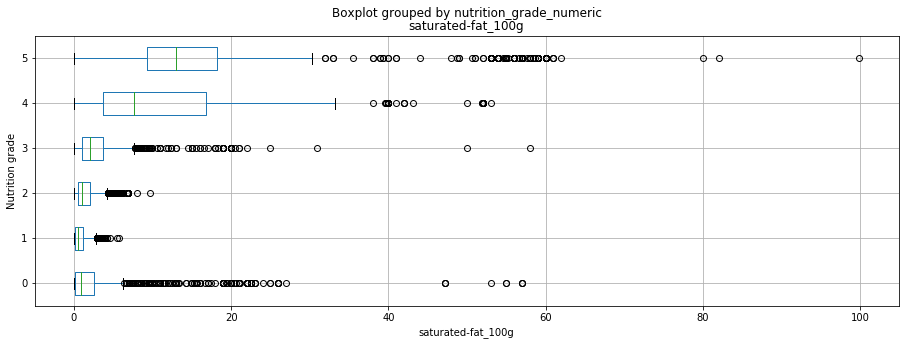

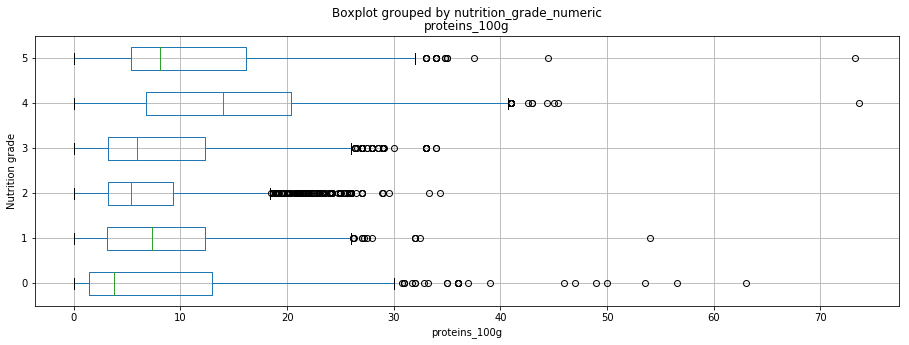

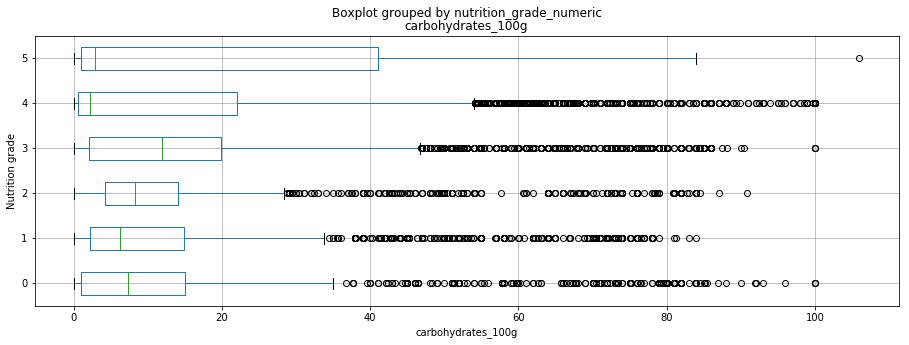

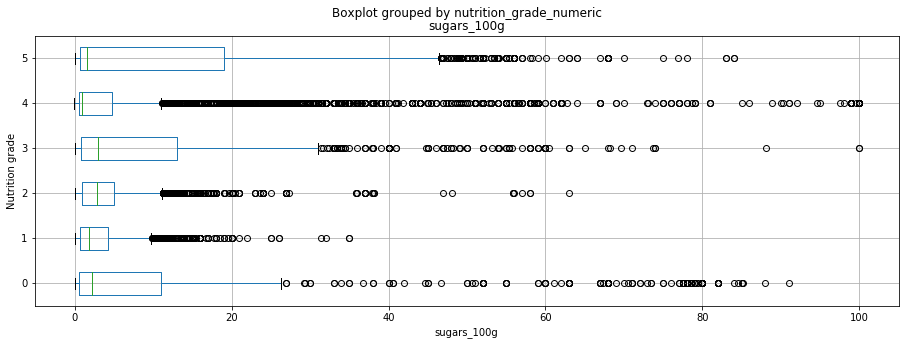

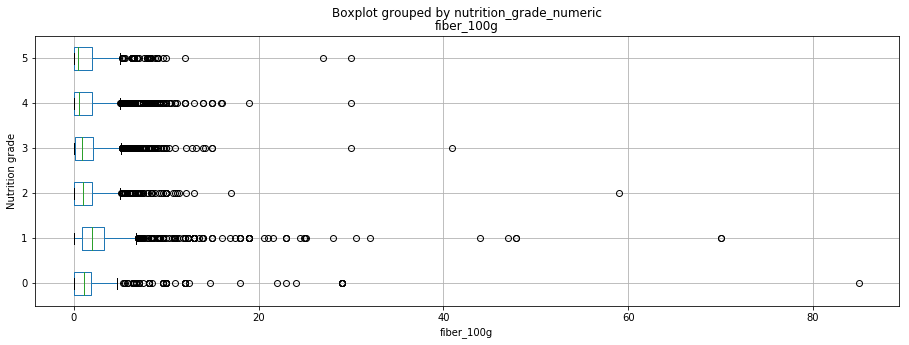

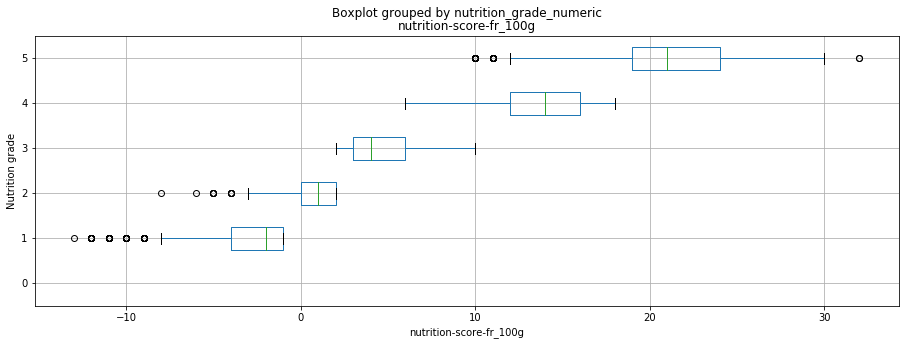

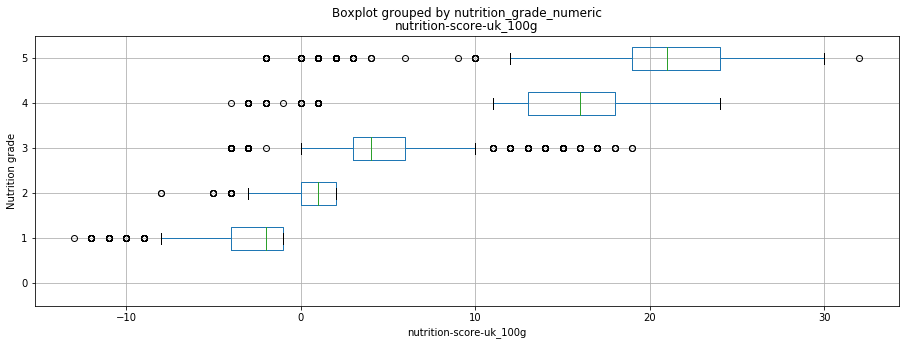

In [67]:
for food_column in ['energy_100g',
       'fat_100g', 'saturated-fat_100g', 'proteins_100g', 'carbohydrates_100g',
       'sugars_100g', 'fiber_100g', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g']:
    dataframe.boxplot(column=food_column, 
                  by='nutrition_grade_numeric', 
                  vert=False, figsize=(15, 5)
                 )
    plt.xlabel(food_column)#"Mean income of the purchase town (in €)")
    plt.ylabel("Nutrition grade")
    #plt.title("Distribution of the sold food items with regard to the median income of the purchase town.")
    plt.show()

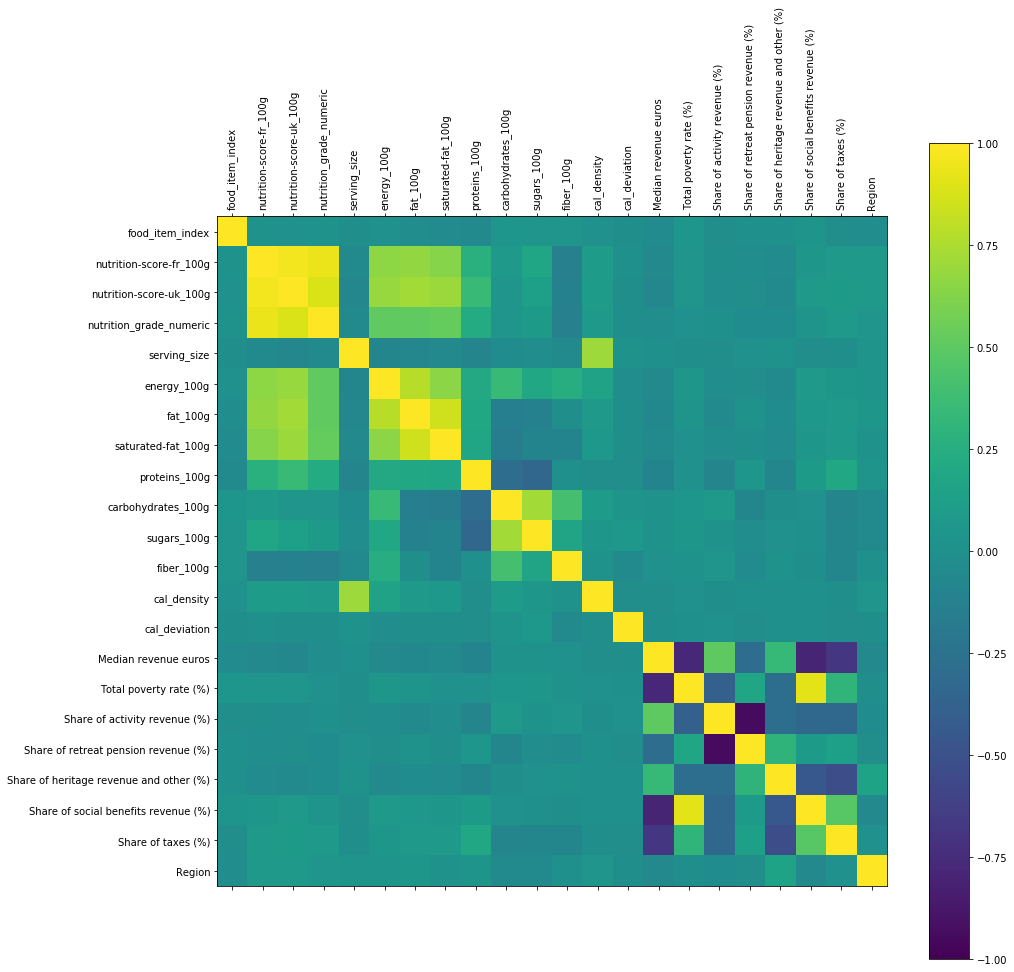

In [68]:
correlations = dataframe.corr()
names = list(correlations.columns)
# plot correlation matrix
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0, len(names), 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.xticks(rotation='vertical')
plt.show()

We see that there is no correlation between the nutrition grade or any other food-related feature, and the income-related features.

There is however a small (~0.6) positive correlation between the nutrition grade and the amount of energy, fat, and saturated in a food item.

Le score est calculé par un système de points, le score le plus faible étant le meilleur.

- éléments défavorables au score : apport calorique pour 100 grammes, teneur en sucre, en graisses saturées et en sel.

- éléments favorables au score : teneur en fruits, légumes, légumineuses et oléagineux, teneur en fibres, et enfin teneur en protéines.

In [69]:
nutri_score = ((dataframe['energy_100g'] / dataframe['energy_100g'].std()) 
+ (dataframe['fat_100g'] / dataframe['fat_100g'].std()) 
+ (dataframe['saturated-fat_100g'] / dataframe['saturated-fat_100g'].std())
+ (dataframe['sugars_100g'] / dataframe['sugars_100g'].std())) 
nutri_score = nutri_score.divide((dataframe['fiber_100g'] / dataframe['fiber_100g'].std()) +
                                 (dataframe['proteins_100g'] / dataframe['proteins_100g'].std()))
nutri_score = nutri_score.replace([np.inf, -np.inf], np.nan)

In [70]:
nutri_score_noNa = dataframe['energy_100g'].fillna(0) / dataframe['energy_100g'].fillna(0).std() 
+ dataframe['fat_100g'].fillna(0) / dataframe['fat_100g'].fillna(0).std()
+ dataframe['saturated-fat_100g'].fillna(0) / dataframe['saturated-fat_100g'].fillna(0).std()
+ dataframe['sugars_100g'].fillna(0) / dataframe['sugars_100g'].fillna(0).std()
nutri_score_noNa = nutri_score_noNa.replace([np.inf, -np.inf], np.nan)

In [71]:
pearson_coeff = dataframe['Median revenue euros'].corr(nutri_score)
print('The Pearson coefficient between nutrition score and median revenue is: {pearson:.3f}'
      .format(pearson=pearson_coeff))

The Pearson coefficient between nutrition score and median revenue is: 0.049


In [72]:
pearson_coeff = dataframe['Total poverty rate (%)'].corr(nutri_score)
print('The Pearson coefficient between nutrition score and total poverty rate is: {pearson:.3f}'
      .format(pearson=pearson_coeff))

The Pearson coefficient between nutrition score and total poverty rate is: -0.039


In [73]:
pearson_coeff = dataframe['Share of social benefits revenue (%)'].corr(nutri_score)
print('The Pearson coefficient between nutrition score and the share of social benefits in the income is: {pearson:.3f}'
      .format(pearson=pearson_coeff))

The Pearson coefficient between nutrition score and the share of social benefits in the income is: -0.025


In [74]:
dataframe['nutri_score'] = nutri_score_noNa

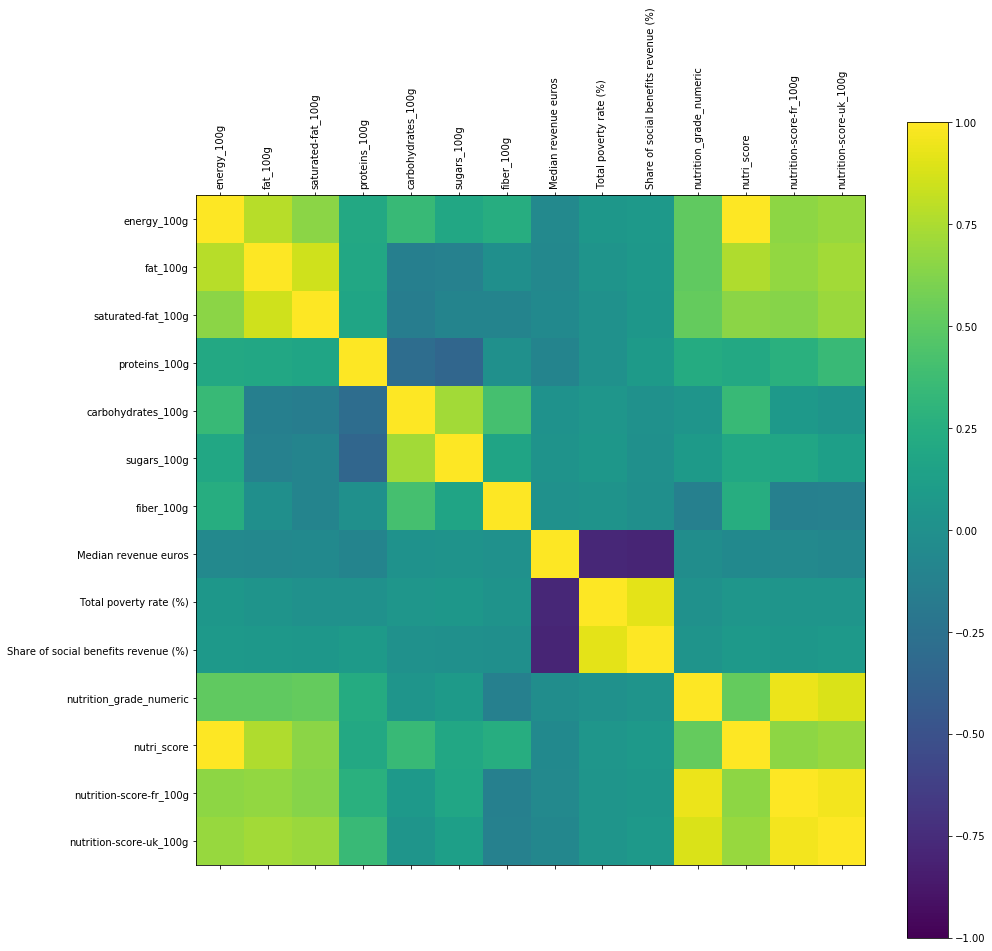

In [75]:
correlations_2 = dataframe[['energy_100g',
                            'fat_100g', 'saturated-fat_100g', 'proteins_100g', 'carbohydrates_100g',
                            'sugars_100g', 'fiber_100g', 'Median revenue euros', 'Total poverty rate (%)',
                            'Share of social benefits revenue (%)', 'nutrition_grade_numeric', 'nutri_score', 
                            'nutrition-score-fr_100g', 'nutrition-score-uk_100g']].corr()
names = list(correlations_2.columns)
# plot correlation matrix
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations_2, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0, len(names), 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.xticks(rotation='vertical')
plt.show()

# Visualization

In [76]:
map_df = pd.read_csv("../data/processed/clean_food_cities_arrond.csv")

/home/wilhelm/Documents/EPFL/applied_data_analysis/.env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (29,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [77]:
df_revenue = map_df[['custom_arrondissement_code', 'Median revenue euros']].dropna().groupby('custom_arrondissement_code').median().reset_index()

In [78]:
scale = np.linspace(np.min(df_revenue['Median revenue euros']), np.max(df_revenue['Median revenue euros']), 6)
scale

array([13812.4137931 , 18475.05603448, 23137.69827586, 27800.34051724,
       32462.98275862, 37125.625     ])

In [79]:
map_revenue = folium.Map(location=[46.5, 2.3], tiles='cartodbpositron', zoom_start=6)

In [80]:
# geojson: https://github.com/gregoiredavid/france-geojson
arr_borders = json.load(open("../data/raw/arrondissements.geojson"))

In [81]:
# This does work
map_revenue.choropleth(geo_data=arr_borders, 
                   data=df_revenue, 
                   columns=['custom_arrondissement_code', 'Median revenue euros'],
                   key_on='feature.properties.code',
                   legend_name='Median revenue in euros',
                   threshold_scale=list(scale),
                   fill_color='OrRd',fill_opacity=0.7, line_opacity=0.2,
                      )

map_revenue.save("../data/processed/map_revenue.html")

In [82]:
display(HTML("<a href='../data/processed/map_revenue.html' target='_blank'>Median revenue</a>"))

In [83]:
df_nutrition_geo = map_df[
    ['custom_arrondissement_code', 'nutrition_grade_numeric', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g']
].dropna().groupby('custom_arrondissement_code').median().reset_index()

In [84]:
df_nutrition_geo.describe()

,nutrition_grade_numeric,nutrition-score-fr_100g,nutrition-score-uk_100g
count,440.000000,440.000000,440.000000
mean,3.314773,8.998864,9.593182
std,1.050712,7.032264,7.980925
min,1.000000,-10.000000,-10.000000
25%,3.000000,3.000000,3.000000
50%,3.500000,10.000000,10.000000
75%,4.000000,14.000000,17.000000
max,5.000000,26.000000,26.000000


In [85]:
for column in ['nutrition_grade_numeric', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g']:
    map_nutrition = folium.Map(location=[46.5, 2.3], tiles='cartodbpositron', zoom_start=6)
    scale = np.linspace(np.min(df_nutrition_geo[column]), np.max(df_nutrition_geo[column]), 6)
    map_nutrition.choropleth(geo_data=arr_borders, 
                           data=df_nutrition_geo, 
                           columns=['custom_arrondissement_code', column],
                           key_on='feature.properties.code',
                           legend_name=column,
                           threshold_scale=list(scale),
                           fill_color='OrRd',fill_opacity=0.7, line_opacity=0.2,
                      )

    map_nutrition.save("../data/processed/map_{}.html".format(column))
    display(HTML("<a href='../data/processed/map_{0}.html' target='_blank'>{0}</a>".format(column)))

In [86]:
df_nutrition_revenue_geo = map_df[
    ['custom_arrondissement_code', 'Median revenue euros', 'nutrition_grade_numeric', 
     'nutrition-score-fr_100g', 'nutrition-score-uk_100g']
].dropna().groupby('custom_arrondissement_code').agg({
    'Median revenue euros': ['mean', 'median'],
    'nutrition_grade_numeric': ['mean', 'median'],
    'nutrition-score-fr_100g': ['mean', 'median'],
    'nutrition-score-uk_100g': ['mean', 'median'],
}).reset_index()
df_nutrition_revenue_geo.columns = ['_'.join(col).strip().strip('_') for col in df_nutrition_revenue_geo.columns.values]
for measure in ['mean', 'median']:
    for column in ['nutrition_grade_numeric', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g']:
        df_nutrition_revenue_geo[
            'comparison_revenue_{column}_{measure}'.format(column=column, measure=measure)
        ] = df_nutrition_revenue_geo[
            '{column}_{measure}'.format(column=column, measure=measure)
        ] / df_nutrition_revenue_geo['Median revenue euros_{measure}'.format(measure=measure)]
        map_nutrition = folium.Map(location=[46.5, 2.3], tiles='cartodbpositron', zoom_start=6)
        scale = np.linspace(
            np.min(df_nutrition_revenue_geo[
                'comparison_revenue_{column}_{measure}'.format(column=column, measure=measure)
            ]), 
            np.max(df_nutrition_revenue_geo[
                'comparison_revenue_{column}_{measure}'.format(column=column, measure=measure)
            ]), 6)
        map_nutrition.choropleth(geo_data=arr_borders, 
                               data=df_nutrition_revenue_geo, 
                               columns=['custom_arrondissement_code', 
                                        'comparison_revenue_{column}_{measure}'
                                        .format(column=column, measure=measure)],
                               key_on='feature.properties.code',
                               legend_name='comparison_revenue_{column}_{measure}'
                                 .format(column=column, measure=measure),
                               threshold_scale=list(scale),
                               fill_color='OrRd',fill_opacity=0.7, line_opacity=0.2,
                          )

        map_nutrition.save("../data/processed/map_{}.html".format(
            'comparison_revenue_{column}_{measure}'.format(column=column, measure=measure)
        ))
        display(HTML("<a href='../data/processed/map_{0}.html' target='_blank'>{0}</a>".format(
            'comparison_revenue_{column}_{measure}'.format(column=column, measure=measure)
        )))